<a href="https://colab.research.google.com/github/Raanank10/Instagram-s-influencers/blob/Eladk_20210928/Instagram_influencers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instagram_influencers**

# Global Parameters

In [676]:
path = 'https://raw.githubusercontent.com/Raanank10/Instagram-s-influencers/main/ai_posts_analysis_data.xlsx'
fname = 'ai_posts_analysis_data.xlsx'
# fname = 'https://github.com/Raanank10/Instagram-s-influencers/blob/ai_posts_analysis_data.xlsx'
# fname = 'https://github.com/Raanank10/Instagram-s-influencers/blob/main/ai_posts_analysis_data.xlsx'


train_size = 0.75
rand_state = 990
sigma = 3


In [677]:
# Bining
bin_labels=['Low','Medium','High', 'Very High','Extreme']

# Get the Data

In [678]:
# General Tools
import numpy as np
import scipy as sp
import pandas as pd
import missingno as msno

# SK Learn
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score , confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report # elad 20210708
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.preprocessing import OrdinalEncoder # elad 20210911

# Trees Visualization
import pydot
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO

# For scoring
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

# Misc
import warnings
from sys import modules
from time import time
from platform import python_version

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go

# IPython
from IPython.display import Image, display

# Confuguration
warnings.filterwarnings('ignore')
%matplotlib inline

In [679]:
df = pd.read_csv(path, index_col=0)  
df.head()

,USERID,USERNAME,FULLNAME,FOLLOWER,POST ID,SHORTCODE,LIKES,COMMENTS,ENGAGEMENT,URL,ACCESSIBILITY CAPTION,CAPTION,LOCATION,CITY,COUNTRY,TIME,IMAGE LABELS,CAPTION INTEREST,ACCESSIBILITY CAPTION INTEREST,IMAGE LABEL INTEREST,IMAGE URL,COMMENT DISABLED,IS VIDEO,HAS AUDIO,VIDEO URL,VIDEO VIEW COUNT
1,,,,,,,,,,,,,,,,,,,,,,,,,,
1918,36193140327,elastici_e_passamaneria,Elastici e Passamaneria,1052,2530600951335029174,CMegChUlwm2,23,0,2.19,https://www.instagram.com/p/CMegChUlwm2,"Photo by Elastici e Passamaneria on March 16, 2021.",FFP2 MADE IN ITALY????????#ffp2mask#italianstyle#madeinitaly????????#produzionepropria#produttori#farmacie#farmacieitaliane#parafarmacia#mascherinelavabili#mask#ffp2,NaN,NaN,NaN,1615891163,"Clothing, Apparel, Text, Money, Collage, Advertisement, Poster",education,movies,business,https://instagram.fdok2-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/c0.180.1440.1440a/s640x640/160374486_2823675294516254_158720847037227315_n.jpg?tp=1&_nc_ht=instagram.fdok2-1.fna.fbcdn.net&_nc_cat=102&_nc_ohc=fXOFeWEt3dcAX9moTcA&edm=ABfd0MgBAAAA&ccb=7-4&oh=cc36e9f840bc93314fcc9e76c9e4b8c6&oe=60DA4B27&_nc_sid=7bff83,no,no,no,NaN,NaN
1919,8210198494,pamela.latorre.73,Pamela La Torre,309,2595285287724490476,CQETjgBnZ7s,55,23,25.24,https://www.instagram.com/p/CQETjgBnZ7s,"Photo by Pamela La Torre on June 13, 2021. May be an image of one or more people, people standing and indoor.",Prima comunione Giorgio,Santissimo Crocifisso,"Taranto, Italy",NaN,1623602137,"Person, Human, Photographer, Photography, Photo, Furniture, Shoe, Clothing, Footwear, Apparel, Interior Design, Indoors",news,arts_entertainment,style_fashion,https://instagram.fhel3-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/s640x640/131454075_203114518334788_1962979990399529842_n.jpg?tp=1&_nc_ht=instagram.fhel3-1.fna.fbcdn.net&_nc_cat=104&_nc_ohc=XmsE8bbC2cIAX-0rYFU&edm=ABfd0MgBAAAA&ccb=7-4&oh=4ca96de8a58eafc0ac1e2eea47d28236&oe=60D9DF1A&_nc_sid=7bff83,no,no,no,NaN,NaN
1920,36838177086,ilaria._004,????????????????,649,2356209223949454778,CCy784yAY26,138,2,21.57,https://www.instagram.com/p/CCy784yAY26,"Photo by ???????????????? on July 18, 2020. May be an image of 1 person.",mirame????,NaN,NaN,NaN,1595102049,"Clothing, Apparel, Person, Human, Female, Swimwear, Footwear, Woman, Bikini, Shoe, Skin, Pants, Flooring, Girl",education,arts_entertainment,style_fashion,https://instagram.fgua5-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/c0.86.1080.1080a/s640x640/111218478_173463267523124_4585802501296990831_n.jpg?tp=1&_nc_ht=instagram.fgua5-1.fna.fbcdn.net&_nc_cat=108&_nc_ohc=3eLtxoYSgkUAX-UqCUh&edm=ABfd0MgBAAAA&ccb=7-4&oh=8ca65c0f03f5315391059b88e4879625&oe=60DAB7D9&_nc_sid=7bff83,no,no,no,NaN,NaN
1921,33286901341,wellbishstore,Wellbish Store,188,2462740031272344745,CItaQKiH1yp,6,0,3.19,https://www.instagram.com/p/CItaQKiH1yp,"Photo by Wellbish Store on December 12, 2020. May be an image of jewelry.",How sweet is your Heart? ❤️????\n.\n.\n???? Follow @wellbishstore\n???? Turn notification on\n☑️ Tag me in your stories\n???? click the link in my bio! ????\n.\n.\n#wellbishstore #relationship #love #boyfriend #girlfriend #bracelet #key #heart #jewelry #engagement #sweethearts,NaN,NaN,NaN,1607801511,"Pendant, Accessories, Accessory, Goggles",style_fashion,arts_entertainment,style_fashion,https://instagram.fhyd2-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/s640x640/130800364_391796488911604_6608581821876444117_n.jpg?tp=1&_nc_ht=instagram.fhyd2-1.fna.fbcdn.net&_nc_cat=104&_nc_ohc=aNFdVzB8RNkAX-OmQYk&edm=ABfd0MgBAAAA&ccb=7-4&oh=d33040e44bb815f94e36b16550c6dbac&oe=60D955AB&_nc_sid=7bff83,no,no,no,NaN,NaN
1922,5633363536,amineblc,Mohamed Amine,1103,2127311663854320191,B2Fuq_ylPo_,46,4,4.53,https://www.instagram.com/p/B2Fuq_ylPo_,Photo by Mohamed Amine in Mawazine.,NaN,Mawazine,"Ksar Hellal, Tunisia",Tunisia,1567815333,"Clothing, Apparel, Person, Human, Sunglasses, Accessories, Accessory, Face, Scarf, Portrait, Photography, Photo, Glasses, People, Selfie, Female, Coat, Smile",NaN,news,style_fashion,https://ins

In [680]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4792 entries, 1918 to 6709
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   USERID                          4792 non-null   int64  
 1   USERNAME                        4792 non-null   object 
 2   FULLNAME                        4666 non-null   object 
 3   FOLLOWER                        4792 non-null   int64  
 4   POST ID                         4792 non-null   int64  
 5   SHORTCODE                       4792 non-null   object 
 6   LIKES                           4792 non-null   int64  
 7   COMMENTS                        4792 non-null   int64  
 8   ENGAGEMENT                      4792 non-null   float64
 9   URL                             4792 non-null   object 
 10  ACCESSIBILITY CAPTION           3943 non-null   object 
 11  CAPTION                         4310 non-null   object 
 12  LOCATION                       

# EDA

Column names: Replace white spaces with underscore 

In [681]:
df.columns = df.columns.str.replace(' ', '_')

Check for each column how many unique is there (lenght of the dataset 4792, len(df)) 

In [682]:
df.apply(lambda col: len(col.unique())).sort_values(ascending=False)

POST_ID                           4792
SHORTCODE                         4792
IMAGE_URL                         4792
URL                               4792
TIME                              4791
IMAGE_LABELS                      4666
CAPTION                           4216
ACCESSIBILITY_CAPTION             3658
ENGAGEMENT                        1415
VIDEO_URL                          809
LIKES                              588
LOCATION                           533
VIDEO_VIEW_COUNT                   472
USERNAME                           447
USERID                             447
FULLNAME                           432
FOLLOWER                           418
CITY                               328
COMMENTS                           138
COUNTRY                             44
CAPTION_INTEREST                    36
IMAGE_LABEL_INTEREST                35
ACCESSIBILITY_CAPTION_INTEREST      27
COMMENT_DISABLED                     2
IS_VIDEO                             2
HAS_AUDIO                

## Data Cleaning

In [683]:
# Descriptive statistics for each column
df.describe()

,USERID,FOLLOWER,POST_ID,LIKES,COMMENTS,ENGAGEMENT,TIME,VIDEO_VIEW_COUNT
count,4.792000e+03,4792.000000,4.792000e+03,4792.000000,4792.000000,4792.000000,4.792000e+03,808.000000
mean,2.075851e+10,4737.154633,2.511704e+18,130.603923,10.970993,5.917452,1.613638e+09,3787.849010
std,1.934902e+10,24869.309437,1.817231e+17,996.768347,79.816138,11.570440,2.166305e+07,38903.901192
min,6.121430e+05,1.000000,6.216878e+17,0.000000,0.000000,0.000000,1.388331e+09,3.000000
25%,2.138415e+09,522.000000,2.541024e+18,13.000000,0.000000,1.150000,1.617134e+09,48.000000
50%,1.040845e+10,1338.000000,2.580869e+18,30.000000,2.000000,2.850000,1.621884e+09,144.500000
75%,4.430101e+10,3296.000000,2.595312e+18,77.250000,7.000000,6.782500,1.623605e+09,478.750000
max,4.836575e+10,469270.000000,2.602336e+18,47638.000000,3921.000000,352.000000,1.624443e+09,968807.000000


In [684]:
df = df[df['ENGAGEMENT'].notna()]
print(f'data len = {len(df)}')

data len = 4792


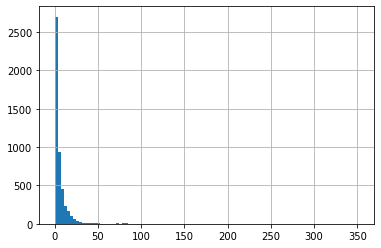

In [685]:
df.ENGAGEMENT.hist(bins=100)

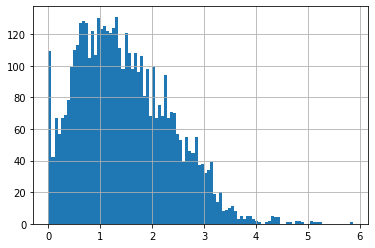

In [686]:
log_ENGAGEMENT = np.log1p(df.ENGAGEMENT)
log_ENGAGEMENT.hist(bins=100)

In [687]:
df['log_ENGAGEMENT'] = log_ENGAGEMENT

## Sigma cleaning

In [688]:
# we lose the most viral posts and most unviral posts
for col in df.columns:
    if df[col].dtype == 'float64':
        std = df[col].std()
        ave = df[col].mean()
        df = df.loc[df[col].between\
                               (ave - (sigma * std), ave + (sigma * std))] 
        print(f'Processing {col:10} --> {df.shape[0]:5} entities entries remain')

Processing ENGAGEMENT -->  4743 entities entries remain
Processing VIDEO_VIEW_COUNT -->   791 entities entries remain
Processing log_ENGAGEMENT -->   789 entities entries remain


In [689]:
df.describe()

,USERID,FOLLOWER,POST_ID,LIKES,COMMENTS,ENGAGEMENT,TIME,VIDEO_VIEW_COUNT,log_ENGAGEMENT
count,7.890000e+02,789.000000,7.890000e+02,789.000000,789.000000,789.000000,7.890000e+02,789.000000,789.000000
mean,1.931264e+10,8617.032953,2.536652e+18,115.242079,8.122940,3.872243,1.616613e+09,977.472750,1.270883
std,1.955563e+10,41894.714181,1.497769e+17,351.746312,19.758025,4.706386,1.785455e+07,3441.862856,0.757684
min,6.121430e+05,11.000000,1.604400e+18,0.000000,0.000000,0.000000,1.505479e+09,3.000000,0.000000
25%,1.806260e+09,587.000000,2.561299e+18,13.000000,0.000000,0.920000,1.619551e+09,48.000000,0.652325
50%,8.329586e+09,1364.000000,2.586370e+18,28.000000,2.000000,2.350000,1.622539e+09,140.000000,1.208960
75%,4.401382e+10,3820.000000,2.596725e+18,68.000000,8.000000,5.080000,1.623774e+09,447.000000,1.805005
max,4.836575e+10,469270.000000,2.602320e+18,4452.000000,312.000000,34.480000,1.624441e+09,30479.000000,3.568969


## Handle NaN valus

How Many NaN values are ther in the datast?

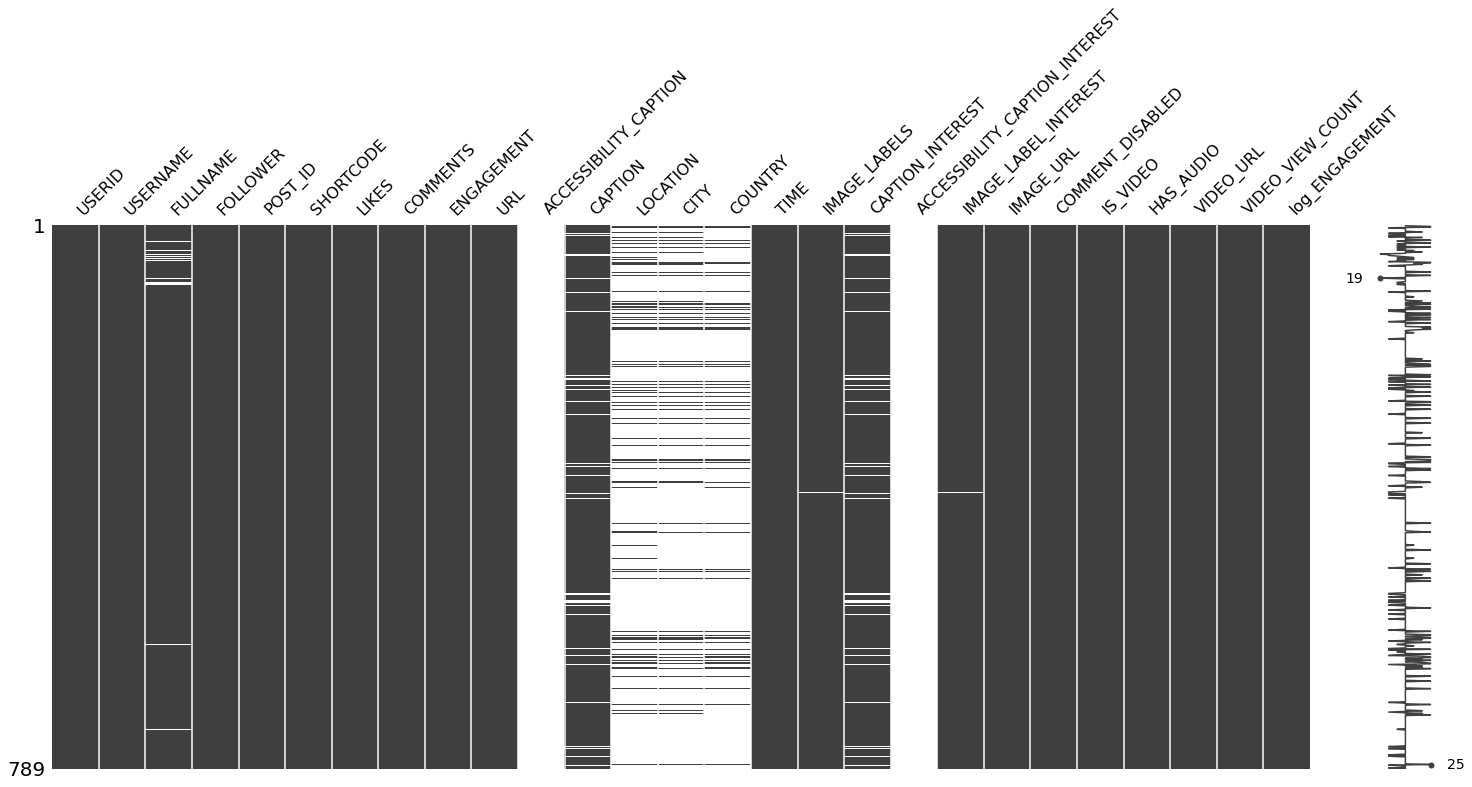

In [690]:
msno.matrix(df)

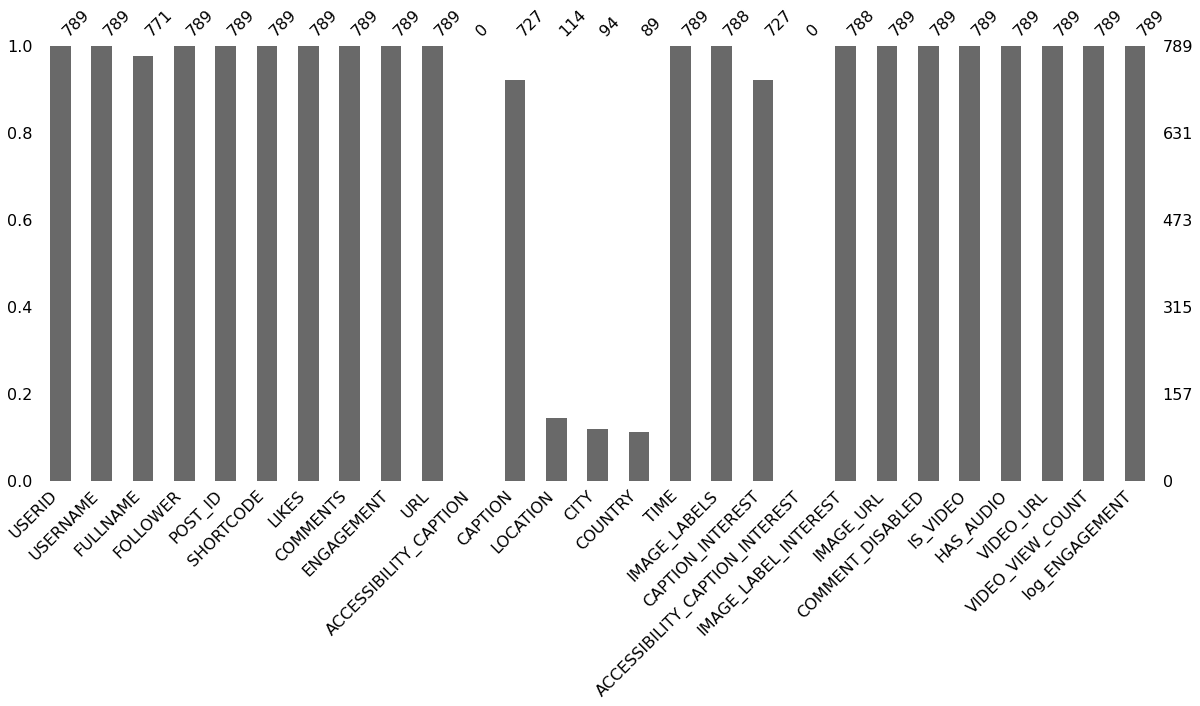

In [691]:
msno.bar(df, figsize=(20, 8))

Conert unix time to separate Date and Time columns

In [692]:
df['DATETIME'] = pd.to_datetime(df['TIME'],unit='s')

In [693]:
df['YEAR'] = pd.DatetimeIndex(df['DATETIME']).year
df['MONTH'] = pd.DatetimeIndex(df['DATETIME']).month
df['DAY'] = pd.DatetimeIndex(df['DATETIME']).day
df['DAYOFWEEK'] = pd.DatetimeIndex(df['DATETIME']).dayofweek
df['HOUR'] = pd.DatetimeIndex(df['DATETIME']).hour
df['MINUTE'] = pd.DatetimeIndex(df['DATETIME']).minute

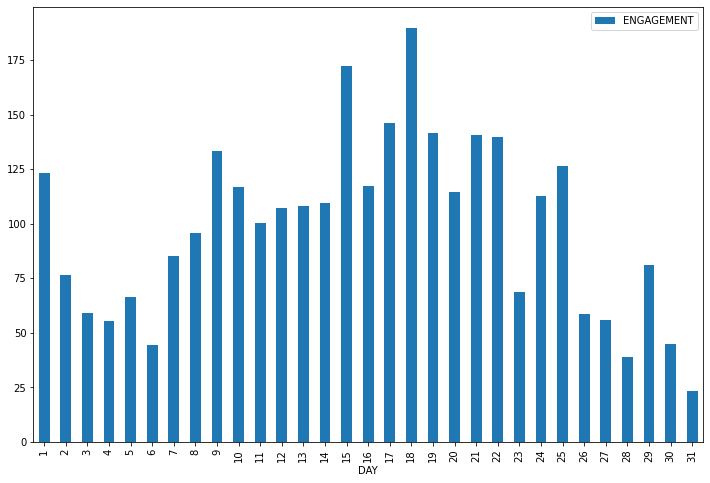

In [694]:
per_DAY = df.groupby(['DAY']).sum()
per_DAY.plot(y=["ENGAGEMENT"], kind="bar",figsize=(12,8))

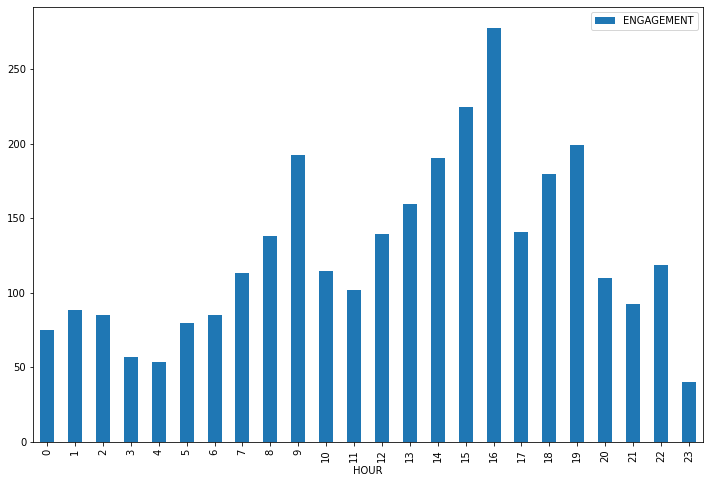

In [695]:
per_HOUR = df.groupby(['HOUR']).sum()
per_HOUR.plot(y=["ENGAGEMENT"], kind="bar",figsize=(12,8))

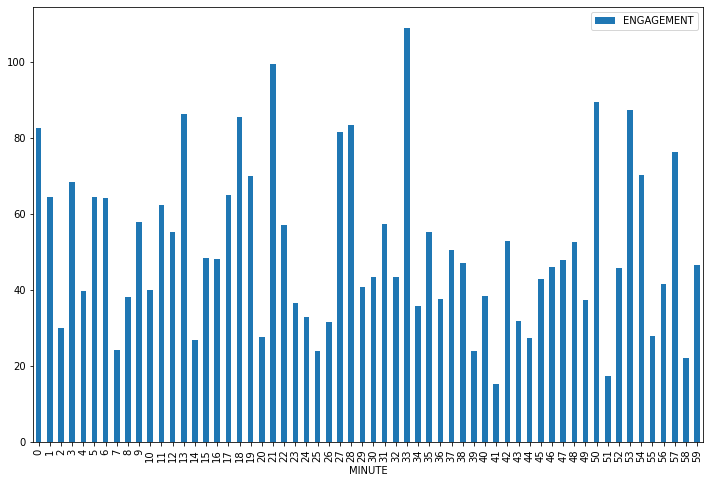

In [696]:
per_MINUTE = df.groupby(['MINUTE']).sum()
per_MINUTE.plot(y=["ENGAGEMENT"], kind="bar",figsize=(12,8))

Text(0, 0.5, 'ENGAGEMENT, LIKES, COMMENTS')

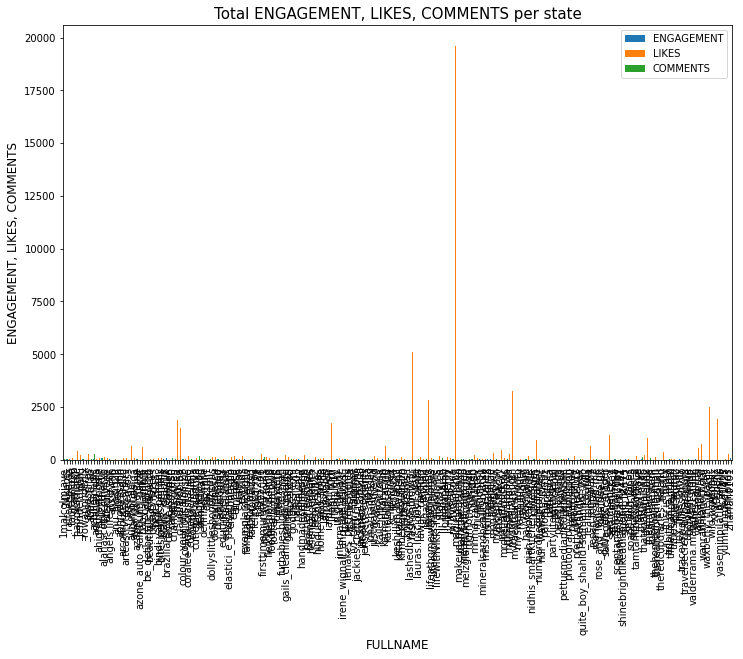

In [697]:
per_FULLNAME = df.groupby(['USERNAME']).sum()
per_FULLNAME.plot(y=["ENGAGEMENT", "LIKES","COMMENTS"], kind="bar",figsize=(12,8))

plt.title("Total ENGAGEMENT, LIKES, COMMENTS per state",fontsize=15)
plt.xlabel('FULLNAME',fontsize=12)
plt.ylabel('ENGAGEMENT, LIKES, COMMENTS',fontsize=12)

Remove column that all values are unique:

In [698]:
for col in df.columns:
    if len(df[col].unique()) == len(df):
        print(col)
        #df.drop(col,inplace=True,axis=1)

POST_ID
SHORTCODE
URL
TIME
IMAGE_URL
VIDEO_URL
DATETIME


In [699]:
df.head()

,USERID,USERNAME,FULLNAME,FOLLOWER,POST_ID,SHORTCODE,LIKES,COMMENTS,ENGAGEMENT,URL,ACCESSIBILITY_CAPTION,CAPTION,LOCATION,CITY,COUNTRY,TIME,IMAGE_LABELS,CAPTION_INTEREST,ACCESSIBILITY_CAPTION_INTEREST,IMAGE_LABEL_INTEREST,IMAGE_URL,COMMENT_DISABLED,IS_VIDEO,HAS_AUDIO,VIDEO_URL,VIDEO_VIEW_COUNT,log_ENGAGEMENT,DATETIME,YEAR,MONTH,DAY,DAYOFWEEK,HOUR,MINUTE
1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1930,2727935277,mr_artworker_,Shivam Rathore⊂(◉‿◉)つ,1319,2580834668183328717,CPQ93T1FJfN,102,8,8.34,https://www.instagram.com/p/CPQ93T1FJfN,NaN,????,NaN,NaN,NaN,1621879514,"Chime, Windchime, Musical Instrument, Lighting",education,NaN,movies,https://instagram.fbdj5-1.fna.fbcdn.net/v/t51.2885-15/e35/c0.210.540.540a/190924481_256953286176258_1031876838247198639_n.jpg?tp=1&_nc_ht=instagram.fbdj5-1.fna.fbcdn.net&_nc_cat=106&_nc_ohc=OA48BLuqTYgAX-Iqzqc&edm=ABfd0MgBAAAA&ccb=7-4&oh=a91ab815b6c33910a077bee56d843668&oe=60D57762&_nc_sid=7bff83,no,yes,yes,https://instagram.fbdj5-1.fna.fbcdn.net/v/t50.2886-16/192196152_467759847856139_5232371712782896118_n.mp4?_nc_ht=instagram.fbdj5-1.fna.fbcdn.net&_nc_cat=111&_nc_ohc=N0ww0YjA_b0AX--nQ_Z&edm=ABfd0MgBAAAA&ccb=7-4&oe=60D58E0D&oh=86c3042dec322c2d8baba1dbd433d1f8&_nc_sid=7bff83,712.0,2.234306,2021-05-24 18:05:14,2021,5,24,0,18,5
1934,267606897,mrssugarbrown,SUG,6334,2592491509517502040,CP6YUrUAcZY,20,4,0.38,https://www.instagram.com/p/CP6YUrUAcZY,NaN,Left or right??? Right or left ? \nWooooooo won? Me or this bitch Iris? ????????????????????\n.\nDrop it like it’s hot! ????????????????????????\n.\nI love you woo foreva,NaN,NaN,NaN,1623269109,"Person, Human, Text, Indoors, Shoe, Clothing, Footwear, Apparel, People, Photography, Photo, Housing, Building, Advertisement, Room, Poster",desserts_baking,NaN,style_fashion,https://instagram.fnsi2-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/c0.280.720.720a/s640x640/199149591_316902469941887_3101135309175204573_n.jpg?tp=1&_nc_ht=instagram.fnsi2-1.fna.fbcdn.net&_nc_cat=111&_nc_ohc=2nxjJKb22RIAX8xe0hL&edm=ABfd0MgBAAAA&ccb=7-4&oh=eaec47557146732ad6358dcd43027d34&oe=60D58C00&_nc_sid=7bff83,no,yes,yes,https://instagram.fnsi2-1.fna.fbcdn.net/v/t50.2886-16/199348256_109695357904873_8438247538929565203_n.mp4?_nc_ht=instagram.fnsi2-1.fna.fbcdn.net&_nc_cat=101&_nc_ohc=CsbObjcni34AX8PnCQo&edm=ABfd0MgBAAAA&ccb=7-4&oe=60D5961A&oh=81e79f9bfc18ede7a2ac7cc399526f0f&_nc_sid=7bff83,135.0,0.322083,2021-06-09 20:05:09,2021,6,9,2,20,5
1935,36633212957,aphrodyssaph,????????????????????????????????????????,585,2342601885032334153,CCCmAC3g0NJ,5,0,0.85,https://www.instagram.com/p/CCCmAC3g0NJ,NaN,Gonna post it on our FB page guys! Link in bio! ✨,Roxas City,"Roxas City, Capiz, Philippines",Philippines,1593480116,"Pants, Clothing, Apparel, Home Decor, Jeans, Denim, Person, Human, Linen, Footwear, Blazer, Jacket, Coat, Shoe",dating_and_relationships,NaN,style_fashion,https://instagram.frkv2-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/c0.90.720.720a/s640x640/106274922_282814052964605_1190390332419036036_n.jpg?tp=1&_nc_ht=instagram.frkv2-1.fna.fbcdn.net&_nc_cat=105&_nc_ohc=tDSKBhZJKZcAX_DKYcE&edm=ABfd0MgBAAAA&ccb=7-4&oh=fb835cfc40b592c9cdcd80f1684862f4&oe=60D528AD&_nc_sid=7bff83,no,yes,yes,https://instagram.frkv2-1.fna.fbcdn.net/v/t50.2886-16/83435862_1530150243812664_7500768797354425992_n.mp4?efg=eyJ2ZW5jb2RlX3RhZyI6InZ0c192b2RfdXJsZ2VuLjcyMC5mZWVkLmRlZmF1bHQiLCJxZV9ncm91cHMiOiJbXCJpZ193ZWJfZGVsaXZlcnlfdnRzX290ZlwiXSJ9&_nc_ht=instagram.frkv2-1.fna.fbcdn.net&_nc_cat=100&_nc_ohc=dnIKBDLJ79cAX_0iN_D&edm=ABfd0MgBAAAA&vs=17870205355841089_3343715150&_nc_vs=HBksFQAYJEdGWWhfUVE0UmJ6ZHFXOEZBSWpfcFB4NkZSaG9ia1lMQUFBRhUAAsgBABUAGCRHQXo5eHdUVTBCMmlYblFBQUE5ck93MnFaXzhyYmtZTEFBQUYVAgLIAQAoAB,61.0,0.615186,2020-06-30 01:21:56,2020,6,30,1,1,21
1951,2727935277,mr_artworker_,Shivam Rathore⊂(◉‿◉)つ,1319,2573482628486636653,CO22NDSlaRt,47,0,3.56,https://www.instagram.com/p/CO22NDSlaRt,NaN,When you don't know what you want to create ???? something else came out\n.\n.\n#aftereffects #loop #animation #vfx #vfxartist #adobe,"In

In [700]:
df.URL.head()
# SHORTCODE
# URL
# IMAGE_URL
# VIDEO_URL # Not working

1
1930    https://www.instagram.com/p/CPQ93T1FJfN
1934    https://www.instagram.com/p/CP6YUrUAcZY
1935    https://www.instagram.com/p/CCCmAC3g0NJ
1951    https://www.instagram.com/p/CO22NDSlaRt
1968    https://www.instagram.com/p/CB7_cWAgF4O
Name: URL, dtype: object

## Remove unneccessary columns from Dataframe

In [701]:
df.drop(['POST_ID','VIDEO_URL','SHORTCODE','IMAGE_URL','USERID','FULLNAME'],inplace=True,axis=1)

Convert columns type to characters :

In [702]:
df['COMMENT_DISABLED'].value_counts()

no     785
yes      4
Name: COMMENT_DISABLED, dtype: int64

In [703]:
df['COMMENT_DISABLED'] = df['COMMENT_DISABLED'].map(dict(yes=1, no=0))

In [704]:
df['IS_VIDEO'] = df['IS_VIDEO'].map(dict(yes=1, no=0))

In [705]:
df['HAS_AUDIO'] = df['HAS_AUDIO'].map(dict(yes=1, no=0))

In [706]:
df[['COMMENT_DISABLED','IS_VIDEO','HAS_AUDIO']].value_counts()

COMMENT_DISABLED  IS_VIDEO  HAS_AUDIO
0                 1         1            704
                            0             81
1                 1         1              4
dtype: int64

In [707]:
pd.unique(df[['COMMENT_DISABLED','IS_VIDEO','HAS_AUDIO']].values.ravel('K'))

array([0, 1])

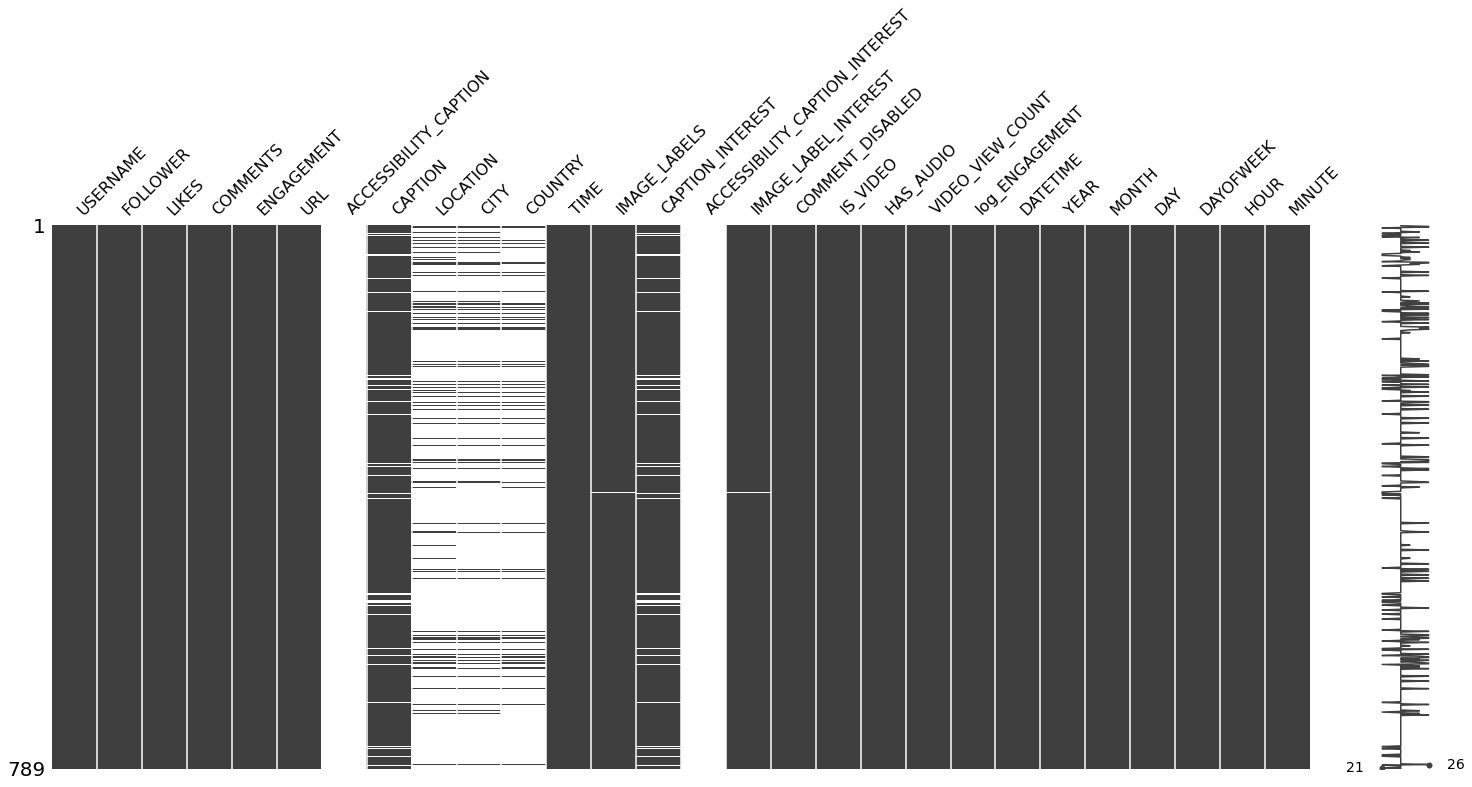

In [708]:
msno.matrix(df)

In [709]:
df.columns

Index(['USERNAME', 'FOLLOWER', 'LIKES', 'COMMENTS', 'ENGAGEMENT', 'URL',
       'ACCESSIBILITY_CAPTION', 'CAPTION', 'LOCATION', 'CITY', 'COUNTRY',
       'TIME', 'IMAGE_LABELS', 'CAPTION_INTEREST',
       'ACCESSIBILITY_CAPTION_INTEREST', 'IMAGE_LABEL_INTEREST',
       'COMMENT_DISABLED', 'IS_VIDEO', 'HAS_AUDIO', 'VIDEO_VIEW_COUNT',
       'log_ENGAGEMENT', 'DATETIME', 'YEAR', 'MONTH', 'DAY', 'DAYOFWEEK',
       'HOUR', 'MINUTE'],
      dtype='object')

Raname the index

In [710]:
df = df.rename_axis('LINE_NUM_INDEX')

Note by Eladk: we can fill location values by using a merdiction model base in the influancer and the time for the post. <BR> 
For Now, I'll just fill the columns with NULL

Replace all cases where VIDEO_VIEW_COUNT == Nan with 0. <BR> for double check i verified it with is_video column

In [711]:
df['VIDEO_VIEW_COUNT'].fillna(0, inplace=True)

Eladk note 8-Sep-2021: I still need to handle missing values in column:


*   FULLNAME
*   ACCESSIBILITY_CAPTION - specify full name, time, location, video or picture and tag
*   CAPTION - the text on this post (by the post uploader
*   LOCATION, CITY, COUNTRY - location
*   CAPTION_INTEREST -
*   ACCESSIBILITY_CAPTION_INTEREST


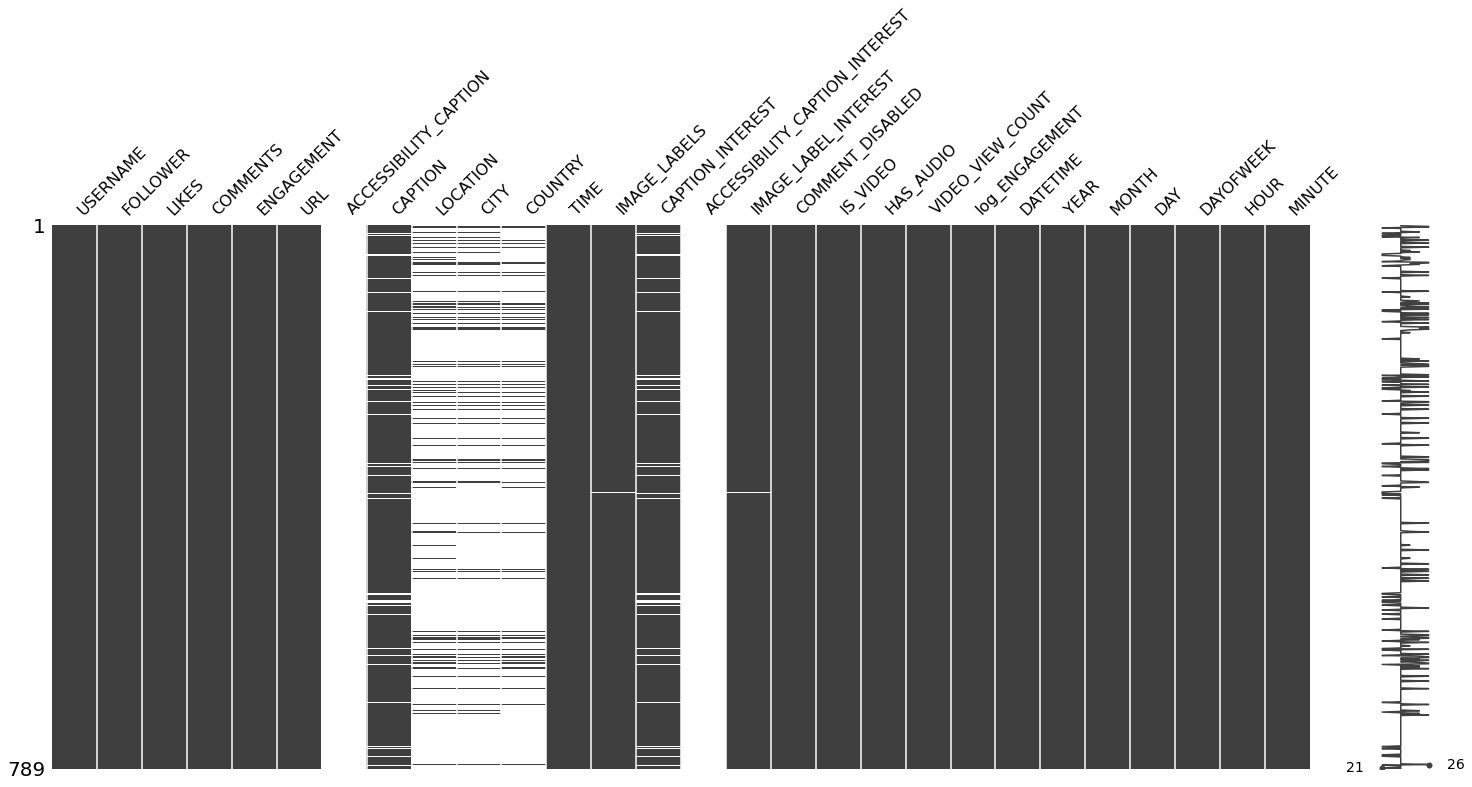

In [712]:
msno.matrix(df)

In [713]:
df.CAPTION.value_counts().sort_values(ascending=False)

????                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      5
#vendors #craftsforsale #stokesfleamarket #fleamarket #lecanto #florida                                                                                                                                                                                                                                                                                                                                                                                                                     

selecting a subset of the data:

In [714]:
df[['ACCESSIBILITY_CAPTION','CAPTION','LOCATION', 'CITY', 'COUNTRY'\
    ,'CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']].head(5)

,ACCESSIBILITY_CAPTION,CAPTION,LOCATION,CITY,COUNTRY,CAPTION_INTEREST,ACCESSIBILITY_CAPTION_INTEREST
LINE_NUM_INDEX,,,,,,,
1930,NaN,????,NaN,NaN,NaN,education,NaN
1934,NaN,Left or right??? Right or left ? \nWooooooo won? Me or this bitch Iris? ????????????????????\n.\nDrop it like it’s hot! ????????????????????????\n.\nI love you woo foreva,NaN,NaN,NaN,desserts_baking,NaN
1935,NaN,Gonna post it on our FB page guys! Link in bio! ✨,Roxas City,"Roxas City, Capiz, Philippines",Philippines,dating_and_relationships,NaN
1951,NaN,When you don't know what you want to create ???? something else came out\n.\n.\n#aftereffects #loop #animation #vfx #vfxartist #adobe,"Indore, India","Indore, Madhya Pradesh, India",India,gaming,NaN
1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Increase the length to a column so that we'll see all the text in a cell

In [715]:
pd.options.display.max_colwidth = 1000
df.ACCESSIBILITY_CAPTION.head(5)

LINE_NUM_INDEX
1930    NaN
1934    NaN
1935    NaN
1951    NaN
1968    NaN
Name: ACCESSIBILITY_CAPTION, dtype: object

Selecting 1 row by index (specific column only)

In [716]:
df[df.index == 1929][['URL','ACCESSIBILITY_CAPTION','DATETIME','LOCATION']] # name, 

,URL,ACCESSIBILITY_CAPTION,DATETIME,LOCATION
LINE_NUM_INDEX,,,,


In [717]:
df.columns

Index(['USERNAME', 'FOLLOWER', 'LIKES', 'COMMENTS', 'ENGAGEMENT', 'URL',
       'ACCESSIBILITY_CAPTION', 'CAPTION', 'LOCATION', 'CITY', 'COUNTRY',
       'TIME', 'IMAGE_LABELS', 'CAPTION_INTEREST',
       'ACCESSIBILITY_CAPTION_INTEREST', 'IMAGE_LABEL_INTEREST',
       'COMMENT_DISABLED', 'IS_VIDEO', 'HAS_AUDIO', 'VIDEO_VIEW_COUNT',
       'log_ENGAGEMENT', 'DATETIME', 'YEAR', 'MONTH', 'DAY', 'DAYOFWEEK',
       'HOUR', 'MINUTE'],
      dtype='object')

In [718]:
df[['CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']].head(20)

,CAPTION_INTEREST,ACCESSIBILITY_CAPTION_INTEREST
LINE_NUM_INDEX,,
1930,education,NaN
1934,desserts_baking,NaN
1935,dating_and_relationships,NaN
1951,gaming,NaN
1968,NaN,NaN
1971,politics,NaN
1972,business,NaN
1973,arts_entertainment,NaN
1978,food_drink,NaN


In [719]:
df[df.index == 1932][['URL','CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']] # name, 

,URL,CAPTION_INTEREST,ACCESSIBILITY_CAPTION_INTEREST
LINE_NUM_INDEX,,,


there are 308 combination as CAPTION_INTEREST and ACCESSIBILITY_CAPTION_INTEREST

In [720]:
df.groupby(['CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']).size().sort_values(ascending=False).reset_index(name='counts').head(50)

,CAPTION_INTEREST,ACCESSIBILITY_CAPTION_INTEREST,counts


there are 35 unique CAPTION_INTEREST


In [721]:
df.groupby(['CAPTION_INTEREST']).size().sort_values(ascending=False).reset_index(name='counts').head(50)

,CAPTION_INTEREST,counts
0,parenting,136
1,arts_entertainment,94
2,education,81
3,style_fashion,73
4,dating_and_relationships,54
5,food_drink,53
6,travel,41
7,music,32
8,news,28
9,movies,20


there are 26 unique ACCESSIBILITY_CAPTION_INTEREST


In [722]:
df.groupby(['ACCESSIBILITY_CAPTION_INTEREST']).size().sort_values(ascending=False).reset_index(name='counts').head(30)

,ACCESSIBILITY_CAPTION_INTEREST,counts


For Now (Eladk 2021-Sep-11) I'll fill every NaN with Null

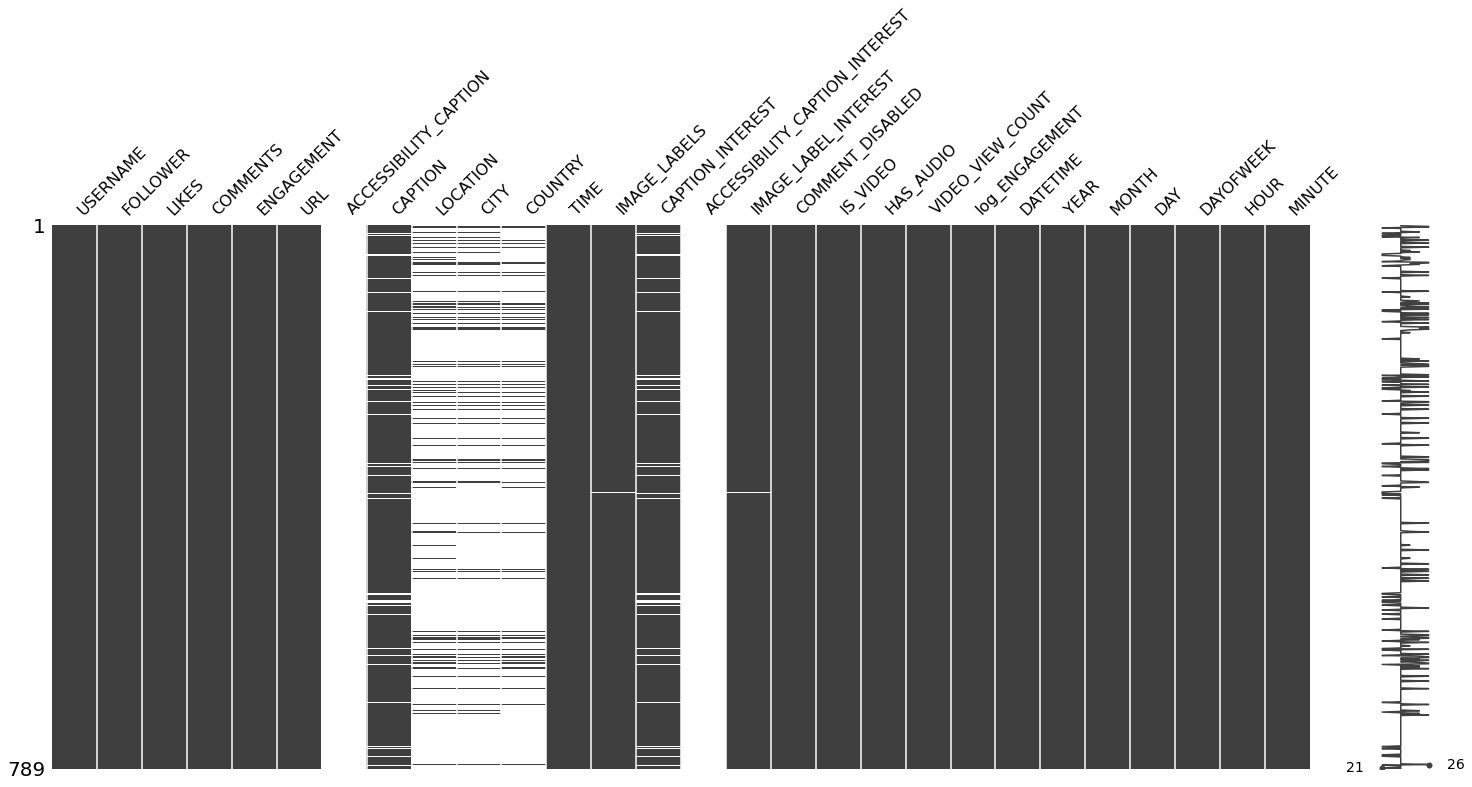

In [723]:
msno.matrix(df)

In [724]:
#https://datatofish.com/rows-with-nan-pandas-dataframe/
#len(df[df['FULLNAME'].isna()]) # 126 #849
#df[df['FULLNAME'].isnull()]
#df[df.isna().any(axis=1)] # len = 4020
# df[df.isnull().any(axis=1)]

In [725]:
for col in df.columns:
    if len(df[df[col].isnull()]) > 0:
      df[col] = df[col].fillna('Null')
      print(col)

ACCESSIBILITY_CAPTION
CAPTION
LOCATION
CITY
COUNTRY
IMAGE_LABELS
CAPTION_INTEREST
ACCESSIBILITY_CAPTION_INTEREST
IMAGE_LABEL_INTEREST


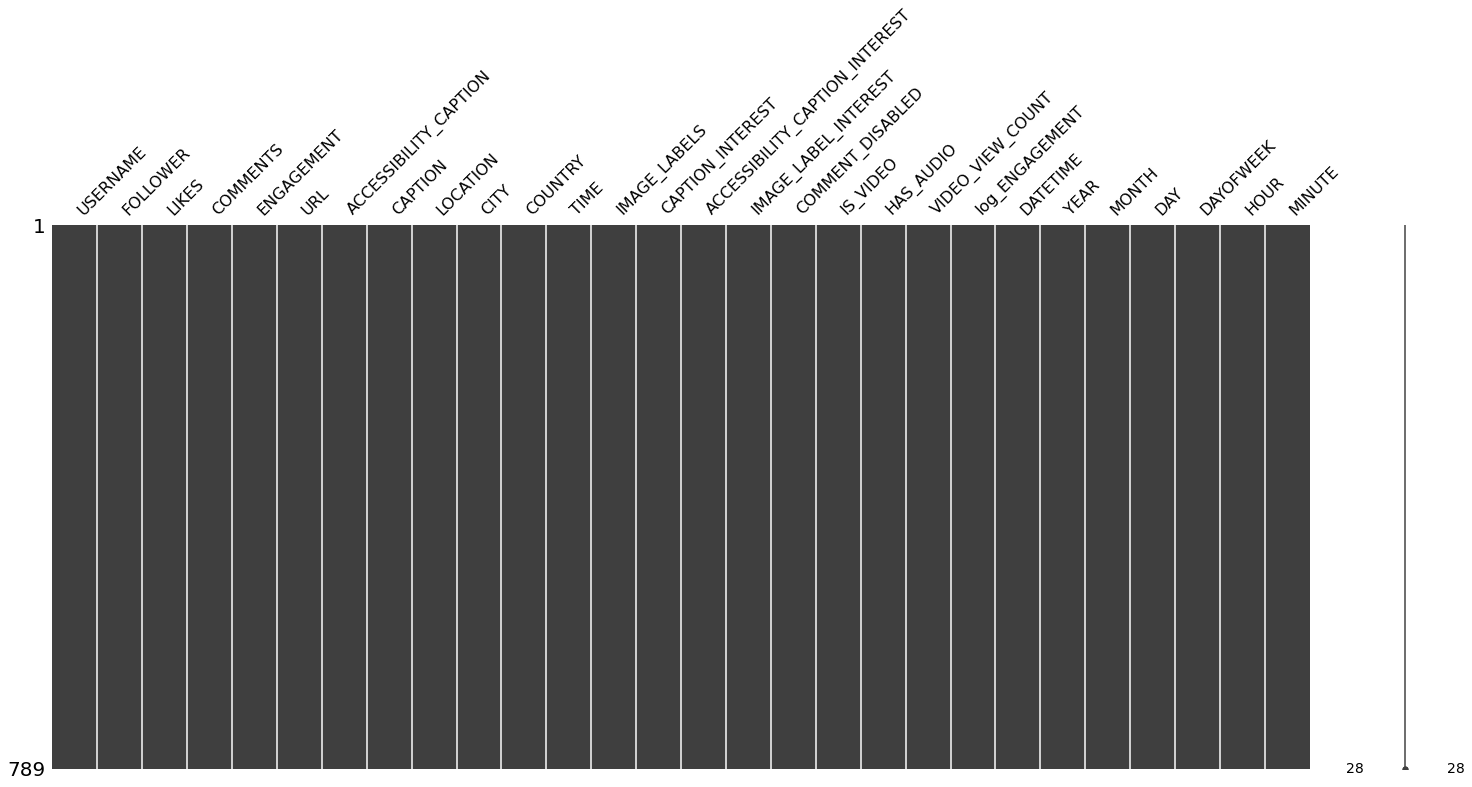

In [726]:
msno.matrix(df)

In [727]:
df.IMAGE_LABEL_INTEREST.unique()

array(['movies', 'style_fashion', 'travel', 'sports',
       'arts_entertainment', 'business', 'music', 'health', 'food_drink',
       'legal', 'events', 'pets', 'gaming', 'technology_computing',
       'entertainment', 'books_literature', 'education',
       'cars_motorcycles', 'parenting', 'fitness', 'weddings',
       'home_garden', 'news', 'hobbies_interests',
       'dating_and_relationships', 'podcasts', 'Null', 'accessories',
       'politics'], dtype=object)

In [728]:
df.IMAGE_LABEL_INTEREST.value_counts()

style_fashion               310
arts_entertainment          111
travel                       72
food_drink                   62
business                     41
movies                       24
sports                       21
technology_computing         17
music                        16
home_garden                  15
events                       14
pets                         13
books_literature             11
entertainment                10
education                     7
parenting                     6
fitness                       5
dating_and_relationships      5
weddings                      5
hobbies_interests             4
health                        4
gaming                        3
cars_motorcycles              3
legal                         3
politics                      2
podcasts                      2
accessories                   1
Null                          1
news                          1
Name: IMAGE_LABEL_INTEREST, dtype: int64

In [729]:
IMAGE_LABEL_INTEREST = df.groupby(['IMAGE_LABEL_INTEREST']).head(10)
print(IMAGE_LABEL_INTEREST)

                     USERNAME  FOLLOWER  LIKES  ...  DAYOFWEEK  HOUR MINUTE
LINE_NUM_INDEX                                  ...                        
1930            mr_artworker_      1319    102  ...          0    18      5
1934            mrssugarbrown      6334     20  ...          2    20      5
1935             aphrodyssaph       585      5  ...          1     1     21
1951            mr_artworker_      1319     47  ...          4    14     37
1968             aphrodyssaph       585      5  ...          5    15     39
...                       ...       ...    ...  ...        ...   ...    ...
6168                 nmpjager      1109     26  ...          1    12     53
6171                 em_pagee      1869     28  ...          5    19     21
6229            libransisters     11498     11  ...          6     9      9
6573            perezjaydagli       168      8  ...          2     2     14
6633             elvisonradio      3576     28  ...          1    20     15

[192 rows x

## Create bins (buckets) of Likes, Comment Engagement so we can use a classification model

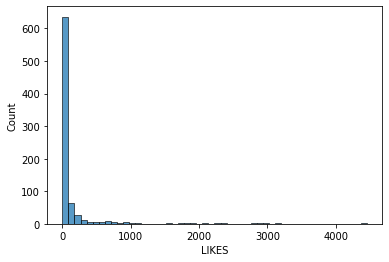

In [730]:
sns.histplot(x = df.LIKES,bins=50)

In [731]:
bins_LIKES=[min(df.LIKES)-1,15,40,200,400,max(df.LIKES)+1]
pd.cut(x=df.LIKES, bins=5).value_counts()
pd.cut(x=df.LIKES, bins=bins_LIKES, labels=bin_labels,
       ordered=True).value_counts()

Low          248
Medium       236
High         223
Extreme       48
Very High     34
Name: LIKES, dtype: int64

In [732]:
df['LIKES_RANK'] = pd.cut(x=df.LIKES, bins=bins_LIKES, labels=bin_labels,
       ordered=True)

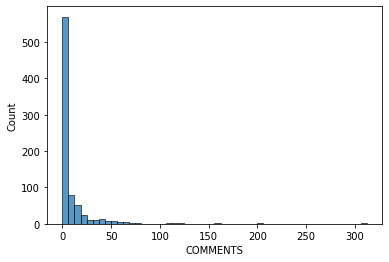

In [733]:
sns.histplot(x = df.COMMENTS,bins=50)

In [734]:
len(df.COMMENTS) #3921

789

In [735]:
bins_COMMENTS=[min(df.COMMENTS)-1,1,5,40,60,max(df.COMMENTS)]
#pd.cut(x=df.COMMENTS, bins=5).value_counts()
pd.cut(x=df.COMMENTS, bins=bins_COMMENTS#, labels=labels 
        ,ordered=True).value_counts()

(-1, 1]      367
(5, 40]      204
(1, 5]       181
(40, 60]      22
(60, 312]     15
Name: COMMENTS, dtype: int64

In [736]:
df['COMMENTS_RANK'] = pd.cut(x=df.COMMENTS, bins=bins_COMMENTS, labels=bin_labels 
        ,ordered=True)

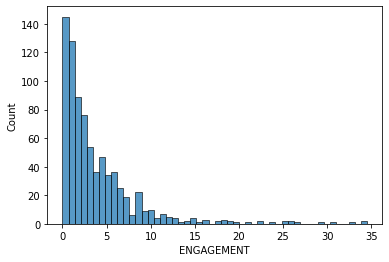

In [737]:
sns.histplot(x = df.ENGAGEMENT,bins=50)

In [738]:
bins_ENGAGEMENT=[min(df.ENGAGEMENT)-1,1.5,3.5,10,15,max(df.ENGAGEMENT)]
pd.cut(x=df.ENGAGEMENT, bins=5, labels=bin_labels, ordered=True).value_counts()
pd.cut(x=df.ENGAGEMENT, bins=bins_ENGAGEMENT, labels=bin_labels, ordered=True).value_counts()

Low          287
High         236
Medium       209
Very High     31
Extreme       26
Name: ENGAGEMENT, dtype: int64

In [739]:
df['ENGAGEMENT_RANK'] = pd.cut(x=df.ENGAGEMENT, bins=bins_ENGAGEMENT, labels=bin_labels, ordered=True)

In [740]:
df['ENGAGEMENT_RANK']

LINE_NUM_INDEX
1930      High
1934       Low
1935       Low
1951      High
1968       Low
         ...  
6663    Medium
6675    Medium
6677    Medium
6678    Medium
6682       Low
Name: ENGAGEMENT_RANK, Length: 789, dtype: category
Categories (5, object): ['Low' < 'Medium' < 'High' < 'Very High' < 'Extreme']

Convert Rank to Code using Dictionary 

In [741]:
df.columns

Index(['USERNAME', 'FOLLOWER', 'LIKES', 'COMMENTS', 'ENGAGEMENT', 'URL',
       'ACCESSIBILITY_CAPTION', 'CAPTION', 'LOCATION', 'CITY', 'COUNTRY',
       'TIME', 'IMAGE_LABELS', 'CAPTION_INTEREST',
       'ACCESSIBILITY_CAPTION_INTEREST', 'IMAGE_LABEL_INTEREST',
       'COMMENT_DISABLED', 'IS_VIDEO', 'HAS_AUDIO', 'VIDEO_VIEW_COUNT',
       'log_ENGAGEMENT', 'DATETIME', 'YEAR', 'MONTH', 'DAY', 'DAYOFWEEK',
       'HOUR', 'MINUTE', 'LIKES_RANK', 'COMMENTS_RANK', 'ENGAGEMENT_RANK'],
      dtype='object')

In [742]:
df.LIKES_RANK.unique()

['High', 'Medium', 'Low', 'Extreme', 'Very High']
Categories (5, object): ['Low' < 'Medium' < 'High' < 'Very High' < 'Extreme']

In [743]:
df['COMMENTS_RANK']

LINE_NUM_INDEX
1930      High
1934    Medium
1935       Low
1951       Low
1968       Low
         ...  
6663       Low
6675    Medium
6677       Low
6678    Medium
6682       Low
Name: COMMENTS_RANK, Length: 789, dtype: category
Categories (5, object): ['Low' < 'Medium' < 'High' < 'Very High' < 'Extreme']

In [744]:
map_dict_rank = {'Low':0.0 , 'Medium':1.0, 'High':2.0, 'Very High':3.0, 'Extreme':4.0}
map_dict_rank

{'Extreme': 4.0, 'High': 2.0, 'Low': 0.0, 'Medium': 1.0, 'Very High': 3.0}

In [745]:
df['LIKES_RANK_INT'] =  df['LIKES_RANK'].map(map_dict_rank).astype(int)

In [746]:
df['COMMENTS_RANK_INT'] =   df['COMMENTS_RANK'].map(map_dict_rank).astype(int)

In [747]:
df['ENGAGEMENT_RANK_INT'] =   df['ENGAGEMENT_RANK'].map(map_dict_rank).astype(int)

In [748]:
df[['LIKES_RANK','LIKES_RANK_INT']].value_counts().sort_index()

LIKES_RANK  LIKES_RANK_INT
Low         0                 248
Medium      1                 236
High        2                 223
Very High   3                  34
Extreme     4                  48
dtype: int64

In [749]:
df[['COMMENTS_RANK','COMMENTS_RANK_INT']].value_counts().sort_index()

COMMENTS_RANK  COMMENTS_RANK_INT
Low            0                    367
Medium         1                    181
High           2                    204
Very High      3                     22
Extreme        4                     15
dtype: int64

In [750]:
df[['ENGAGEMENT_RANK','ENGAGEMENT_RANK_INT']].value_counts().sort_index()

ENGAGEMENT_RANK  ENGAGEMENT_RANK_INT
Low              0                      287
Medium           1                      209
High             2                      236
Very High        3                       31
Extreme          4                       26
dtype: int64

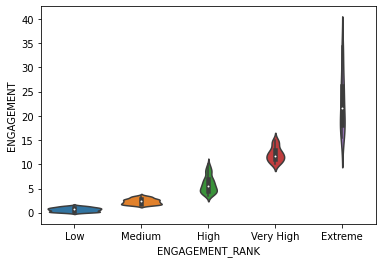

In [751]:
p = sns.violinplot(x='ENGAGEMENT_RANK', y='ENGAGEMENT', 
                    #order=cut_order, 
                    data=df)

## Eladk 28-Sep-2021, more bucketing

In [752]:
s = pd.Series(model_2_dt.feature_importances_*100,
          index=X.columns).sort_values(ascending=False)

s[s.gt(0)]

VIDEO_VIEW_COUNT                      40.219756
FOLLOWER                              34.266308
USERNAME_OBJECT_AS_INT                18.890887
CAPTION_OBJECT_AS_INT                  3.558228
CAPTION_INTEREST_OBJECT_AS_INT         1.585704
IMAGE_LABEL_INTEREST_OBJECT_AS_INT     0.939213
MINUTE                                 0.277403
HOUR                                   0.262500
dtype: float64



1.  VIDEO_VIEW_COUNT          41.148879
2.  FOLLOWER                  35.852012
3.  USERNAME_OBJECT_AS_INT    17.961764
4.  CAPTION_OBJECT_AS_INT      3.558228
5.  HOUR                       1.201713
6.  MINUTE                     0.277403



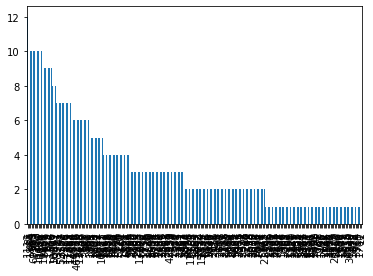

In [753]:
df.FOLLOWER.value_counts().sort_values(ascending=False).plot.bar()
#.reindex()

## Replacing Charecters  with Number uning OrdinalEncoder

In [754]:
# list of char / object columns

In [755]:
df.dtypes

USERNAME                                  object
FOLLOWER                                   int64
LIKES                                      int64
COMMENTS                                   int64
ENGAGEMENT                               float64
URL                                       object
ACCESSIBILITY_CAPTION                     object
CAPTION                                   object
LOCATION                                  object
CITY                                      object
COUNTRY                                   object
TIME                                       int64
IMAGE_LABELS                              object
CAPTION_INTEREST                          object
ACCESSIBILITY_CAPTION_INTEREST            object
IMAGE_LABEL_INTEREST                      object
COMMENT_DISABLED                           int64
IS_VIDEO                                   int64
HAS_AUDIO                                  int64
VIDEO_VIEW_COUNT                         float64
log_ENGAGEMENT      

In [756]:
df.select_dtypes(include=['object']).dtypes

USERNAME                          object
URL                               object
ACCESSIBILITY_CAPTION             object
CAPTION                           object
LOCATION                          object
CITY                              object
COUNTRY                           object
IMAGE_LABELS                      object
CAPTION_INTEREST                  object
ACCESSIBILITY_CAPTION_INTEREST    object
IMAGE_LABEL_INTEREST              object
dtype: object

In [757]:
df.select_dtypes(include=['object']).dtypes.index

Index(['USERNAME', 'URL', 'ACCESSIBILITY_CAPTION', 'CAPTION', 'LOCATION',
       'CITY', 'COUNTRY', 'IMAGE_LABELS', 'CAPTION_INTEREST',
       'ACCESSIBILITY_CAPTION_INTEREST', 'IMAGE_LABEL_INTEREST'],
      dtype='object')

In [758]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 789 entries, 1930 to 6682
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   USERNAME                        789 non-null    object        
 1   FOLLOWER                        789 non-null    int64         
 2   LIKES                           789 non-null    int64         
 3   COMMENTS                        789 non-null    int64         
 4   ENGAGEMENT                      789 non-null    float64       
 5   URL                             789 non-null    object        
 6   ACCESSIBILITY_CAPTION           789 non-null    object        
 7   CAPTION                         789 non-null    object        
 8   LOCATION                        789 non-null    object        
 9   CITY                            789 non-null    object        
 10  COUNTRY                         789 non-null    object        
 11  TI

In [759]:
enc = OrdinalEncoder()

Many columns:

In [760]:
for col in df.select_dtypes(include=['object']).dtypes.index:
#for col in ['USERNAME','FULLNAME']:
  #col_list = pd.DataFrame(df[col].unique())
  #col_list.rename(columns = {0:col},inplace=True)
  #col_list.rename(columns = {0:col},inplace=True)
  enc.fit(df[[col]])
  df[col + '_OBJECT_AS_INT'] = enc.transform(df[[col]])
  #print(col)

In [761]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 789 entries, 1930 to 6682
Data columns (total 45 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   USERNAME                                      789 non-null    object        
 1   FOLLOWER                                      789 non-null    int64         
 2   LIKES                                         789 non-null    int64         
 3   COMMENTS                                      789 non-null    int64         
 4   ENGAGEMENT                                    789 non-null    float64       
 5   URL                                           789 non-null    object        
 6   ACCESSIBILITY_CAPTION                         789 non-null    object        
 7   CAPTION                                       789 non-null    object        
 8   LOCATION                                      789 non-null    obje

In [762]:
df.head(2)

,USERNAME,FOLLOWER,LIKES,COMMENTS,ENGAGEMENT,URL,ACCESSIBILITY_CAPTION,CAPTION,LOCATION,CITY,COUNTRY,TIME,IMAGE_LABELS,CAPTION_INTEREST,ACCESSIBILITY_CAPTION_INTEREST,IMAGE_LABEL_INTEREST,COMMENT_DISABLED,IS_VIDEO,HAS_AUDIO,VIDEO_VIEW_COUNT,log_ENGAGEMENT,DATETIME,YEAR,MONTH,DAY,DAYOFWEEK,HOUR,MINUTE,LIKES_RANK,COMMENTS_RANK,ENGAGEMENT_RANK,LIKES_RANK_INT,COMMENTS_RANK_INT,ENGAGEMENT_RANK_INT,USERNAME_OBJECT_AS_INT,URL_OBJECT_AS_INT,ACCESSIBILITY_CAPTION_OBJECT_AS_INT,CAPTION_OBJECT_AS_INT,LOCATION_OBJECT_AS_INT,CITY_OBJECT_AS_INT,COUNTRY_OBJECT_AS_INT,IMAGE_LABELS_OBJECT_AS_INT,CAPTION_INTEREST_OBJECT_AS_INT,ACCESSIBILITY_CAPTION_INTEREST_OBJECT_AS_INT,IMAGE_LABEL_INTEREST_OBJECT_AS_INT
LINE_NUM_INDEX,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1930,mr_artworker_,1319,102,8,8.34,https://www.instagram.com/p/CPQ93T1FJfN,Null,????,Null,Null,Null,1621879514,"Chime, Windchime, Musical Instrument, Lighting",education,Null,movies,0,1,1,712.0,2.234306,2021-05-24 18:05:14,2021,5,24,0,18,5,High,High,High,2,2,2,162.0,401.0,0.0,54.0,41.0,36.0,9.0,66.0,8.0,0.0,17.0
1934,mrssugarbrown,6334,20,4,0.38,https://www.instagram.com/p/CP6YUrUAcZY,Null,Left or right??? Right or left ? \nWooooooo won? Me or this bitch Iris? ????????????????????\n.\nDrop it like it’s hot! ????????????????????????\n.\nI love you woo foreva,Null,Null,Null,1623269109,"Person, Human, Text, Indoors, Shoe, Clothing, Footwear, Apparel, People, Photography, Photo, Housing, Building, Advertisement, Room, Poster",desserts_baking,Null,style_fashion,0,1,1,135.0,0.322083,2021-06-09 20:05:09,2021,6,9,2,20,5,Medium,Medium,Low,1,1,0,164.0,328.0,0.0,379.0,41.0,36.0,9.0,636.0,7.0,0.0,25.0


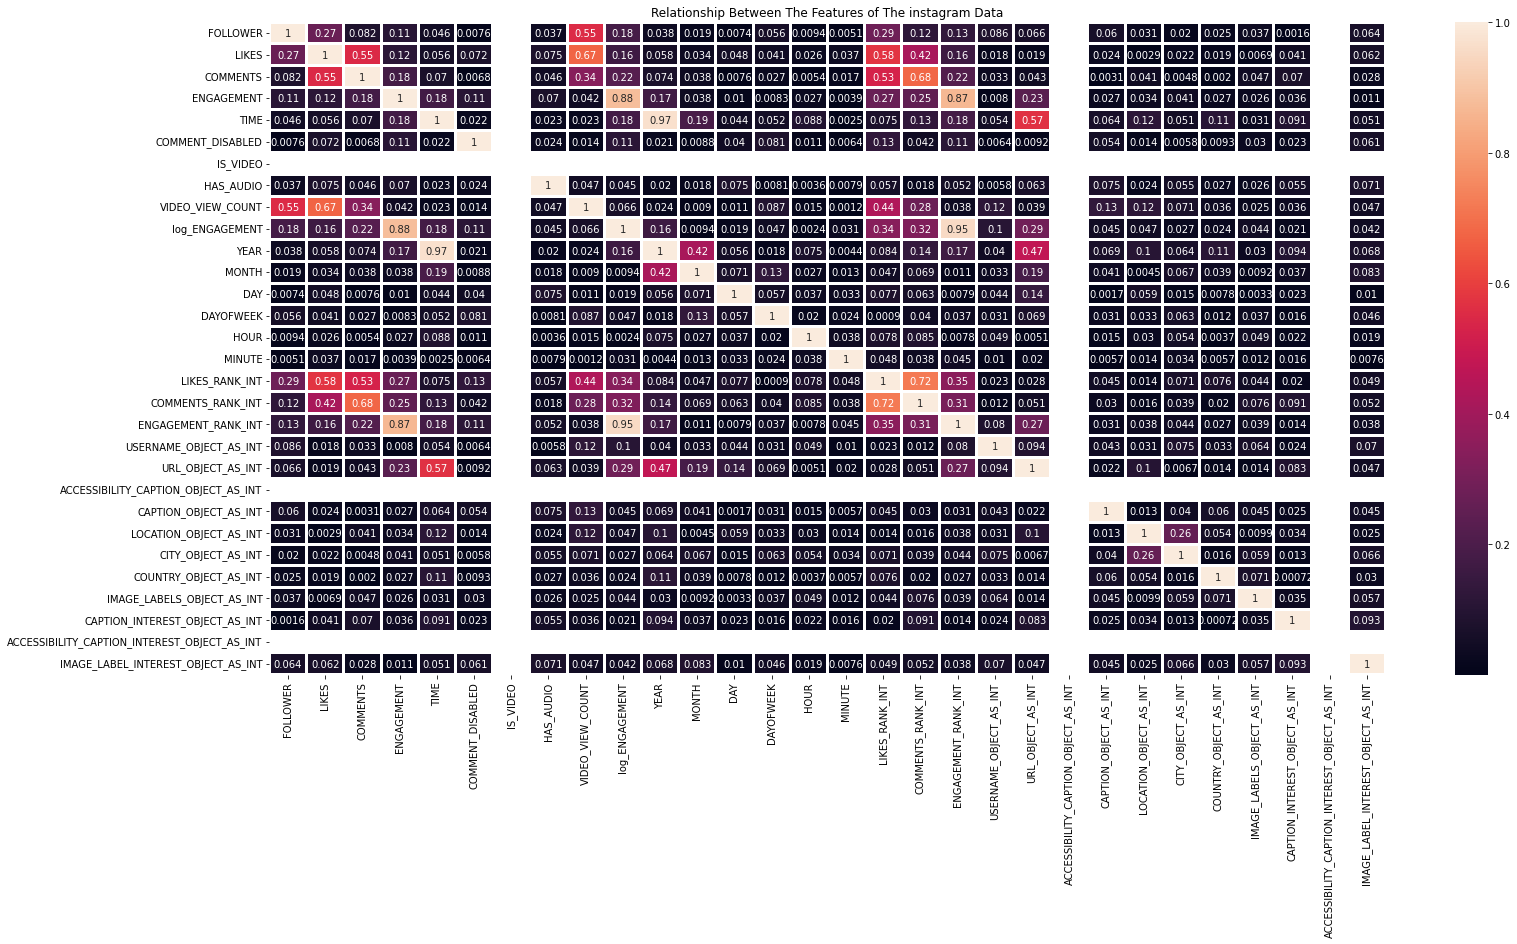

In [763]:
plt.figure(figsize=(25,12))
plt.title("Relationship Between The Features of The instagram Data")
sns.heatmap(df.corr().abs(), annot=True, linewidths = 2, linecolor = "white")

In [764]:
# %%time 
# df = df.select_dtypes(include=np.number)
# sns.pairplot(df ,height=1.8) # takes about 5 min.

## More EDA

In [765]:
df.head(2)

,USERNAME,FOLLOWER,LIKES,COMMENTS,ENGAGEMENT,URL,ACCESSIBILITY_CAPTION,CAPTION,LOCATION,CITY,COUNTRY,TIME,IMAGE_LABELS,CAPTION_INTEREST,ACCESSIBILITY_CAPTION_INTEREST,IMAGE_LABEL_INTEREST,COMMENT_DISABLED,IS_VIDEO,HAS_AUDIO,VIDEO_VIEW_COUNT,log_ENGAGEMENT,DATETIME,YEAR,MONTH,DAY,DAYOFWEEK,HOUR,MINUTE,LIKES_RANK,COMMENTS_RANK,ENGAGEMENT_RANK,LIKES_RANK_INT,COMMENTS_RANK_INT,ENGAGEMENT_RANK_INT,USERNAME_OBJECT_AS_INT,URL_OBJECT_AS_INT,ACCESSIBILITY_CAPTION_OBJECT_AS_INT,CAPTION_OBJECT_AS_INT,LOCATION_OBJECT_AS_INT,CITY_OBJECT_AS_INT,COUNTRY_OBJECT_AS_INT,IMAGE_LABELS_OBJECT_AS_INT,CAPTION_INTEREST_OBJECT_AS_INT,ACCESSIBILITY_CAPTION_INTEREST_OBJECT_AS_INT,IMAGE_LABEL_INTEREST_OBJECT_AS_INT
LINE_NUM_INDEX,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1930,mr_artworker_,1319,102,8,8.34,https://www.instagram.com/p/CPQ93T1FJfN,Null,????,Null,Null,Null,1621879514,"Chime, Windchime, Musical Instrument, Lighting",education,Null,movies,0,1,1,712.0,2.234306,2021-05-24 18:05:14,2021,5,24,0,18,5,High,High,High,2,2,2,162.0,401.0,0.0,54.0,41.0,36.0,9.0,66.0,8.0,0.0,17.0
1934,mrssugarbrown,6334,20,4,0.38,https://www.instagram.com/p/CP6YUrUAcZY,Null,Left or right??? Right or left ? \nWooooooo won? Me or this bitch Iris? ????????????????????\n.\nDrop it like it’s hot! ????????????????????????\n.\nI love you woo foreva,Null,Null,Null,1623269109,"Person, Human, Text, Indoors, Shoe, Clothing, Footwear, Apparel, People, Photography, Photo, Housing, Building, Advertisement, Room, Poster",desserts_baking,Null,style_fashion,0,1,1,135.0,0.322083,2021-06-09 20:05:09,2021,6,9,2,20,5,Medium,Medium,Low,1,1,0,164.0,328.0,0.0,379.0,41.0,36.0,9.0,636.0,7.0,0.0,25.0


## Feature Engneering

## Image captioning

Eladk 2021-Sep-17, we need to:


*   convert y colum to 5 classes so we can have a classification problem and not a regresion model
*   check if the data is inbalance (so we need to use stratify)



# Split the Data

select only int and float column types to X 
seletc LIKES, COMMENTS, ENGAGEMENT as y

In [766]:
df.columns

Index(['USERNAME', 'FOLLOWER', 'LIKES', 'COMMENTS', 'ENGAGEMENT', 'URL',
       'ACCESSIBILITY_CAPTION', 'CAPTION', 'LOCATION', 'CITY', 'COUNTRY',
       'TIME', 'IMAGE_LABELS', 'CAPTION_INTEREST',
       'ACCESSIBILITY_CAPTION_INTEREST', 'IMAGE_LABEL_INTEREST',
       'COMMENT_DISABLED', 'IS_VIDEO', 'HAS_AUDIO', 'VIDEO_VIEW_COUNT',
       'log_ENGAGEMENT', 'DATETIME', 'YEAR', 'MONTH', 'DAY', 'DAYOFWEEK',
       'HOUR', 'MINUTE', 'LIKES_RANK', 'COMMENTS_RANK', 'ENGAGEMENT_RANK',
       'LIKES_RANK_INT', 'COMMENTS_RANK_INT', 'ENGAGEMENT_RANK_INT',
       'USERNAME_OBJECT_AS_INT', 'URL_OBJECT_AS_INT',
       'ACCESSIBILITY_CAPTION_OBJECT_AS_INT', 'CAPTION_OBJECT_AS_INT',
       'LOCATION_OBJECT_AS_INT', 'CITY_OBJECT_AS_INT', 'COUNTRY_OBJECT_AS_INT',
       'IMAGE_LABELS_OBJECT_AS_INT', 'CAPTION_INTEREST_OBJECT_AS_INT',
       'ACCESSIBILITY_CAPTION_INTEREST_OBJECT_AS_INT',
       'IMAGE_LABEL_INTEREST_OBJECT_AS_INT'],
      dtype='object')

In [767]:
X = df.select_dtypes(include=['number'])
X.drop(['LIKES','COMMENTS','ENGAGEMENT','log_ENGAGEMENT'], axis=1, inplace=True) #['LIKES','COMMENTS','ENGAGEMENT']

In [768]:
X.drop(['LIKES_RANK_INT','COMMENTS_RANK_INT','ENGAGEMENT_RANK_INT'], axis=1, inplace=True) #['LIKES','COMMENTS','ENGAGEMENT']

In [769]:
y = df['ENGAGEMENT']
y1 = df['LIKES']
y2 = df['COMMENTS']
y3 = df['log_ENGAGEMENT']
y_ENGAGEMENT_RANK_INT = df['ENGAGEMENT_RANK_INT']
y_LIKES_RANK_INT = df['LIKES_RANK_INT']
y_COMMENTS_RANK_INT = df['COMMENTS_RANK_INT']

In [770]:
X_train, X_test, y_train, y_test = train_test_split(X, y3, train_size = train_size\
                           , random_state = rand_state)#, stratify = df.ENGAGEMENT)

In [771]:
print('Training Features Shape:', X_train.shape)
print('Training Labels (y) Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels(y) Shape:', y_test.shape)

Training Features Shape: (591, 23)
Training Labels (y) Shape: (591,)
Testing Features Shape: (198, 23)
Testing Labels(y) Shape: (198,)


# Mechine Learning  Model

## Appling First1 Model - KNN model

In [772]:
rmse_val = [] #to store rmse values for different k
for K in range(30):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = (mse(y_test,pred))**0.5 #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.8946579013813578
RMSE value for k=  2 is: 0.8170846446564328
RMSE value for k=  3 is: 0.7729565771030925
RMSE value for k=  4 is: 0.7603763887205081
RMSE value for k=  5 is: 0.7509325478504442
RMSE value for k=  6 is: 0.7415409359534267
RMSE value for k=  7 is: 0.7491720360851827
RMSE value for k=  8 is: 0.7460974513950666
RMSE value for k=  9 is: 0.7507590008132964
RMSE value for k=  10 is: 0.7454199084684081
RMSE value for k=  11 is: 0.7350988910681179
RMSE value for k=  12 is: 0.7290406908657124
RMSE value for k=  13 is: 0.7336989118531215
RMSE value for k=  14 is: 0.7338844723303787
RMSE value for k=  15 is: 0.7318491981568765
RMSE value for k=  16 is: 0.7330447086205174
RMSE value for k=  17 is: 0.7317385417461513
RMSE value for k=  18 is: 0.7292482724365411
RMSE value for k=  19 is: 0.7235539193703922
RMSE value for k=  20 is: 0.7213365730279069
RMSE value for k=  21 is: 0.7194606013274931
RMSE value for k=  22 is: 0.7177518594782559
RMSE value for k=  

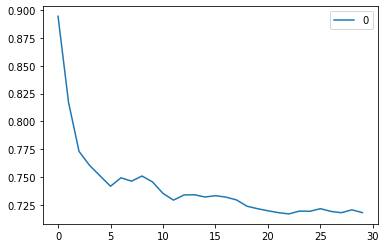

In [773]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [774]:
min_mse_k = min(rmse_val)
min_index = rmse_val.index(min_mse_k)
print(min_index, min_mse_k)

22 0.7166254467244701


In [775]:
neighbor = min_index
knn_model_1 = KNeighborsRegressor(n_neighbors=neighbor).fit(X_train, y_train)

In [776]:
y_train_pred = knn_model_1.predict(X_train)

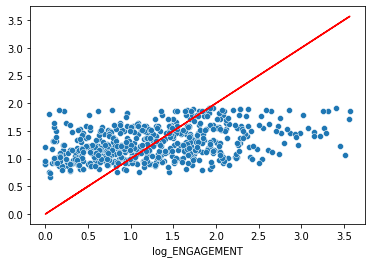

In [777]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [778]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(y_train[-150:]))), y=y_train[-150:],
                         mode='lines',
                         name='Prediction'))
fig.add_trace(go.Scatter(x=list(range(len(y_train_pred[-150:]))), y=y_train_pred[-150:],
                         mode='lines',
                         name='True value'))

fig.show()

## Validating the Model 

In [779]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

0.6939703384354721

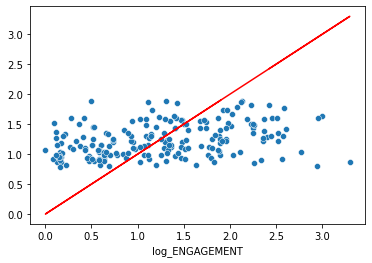

In [780]:
y_test_pred = knn_model_1.predict(X_test)
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [781]:
RMSE = mse(y_test, y_test_pred)**0.5
print('RMSE ', RMSE)

print('r2_score: ', round(r2_score(y_test, y_test_pred)*100, 2))

RMSE  0.7177518594782559
r2_score:  11.56


## Scaled MaxAbsScaler model

In [782]:
my_scaler = MaxAbsScaler().fit(X_train)
X_train_scaled = pd.DataFrame(my_scaler.transform(X_train), columns=X_train.columns)
X_train_scaled.head()

,FOLLOWER,TIME,COMMENT_DISABLED,IS_VIDEO,HAS_AUDIO,VIDEO_VIEW_COUNT,YEAR,MONTH,DAY,DAYOFWEEK,HOUR,MINUTE,USERNAME_OBJECT_AS_INT,URL_OBJECT_AS_INT,ACCESSIBILITY_CAPTION_OBJECT_AS_INT,CAPTION_OBJECT_AS_INT,LOCATION_OBJECT_AS_INT,CITY_OBJECT_AS_INT,COUNTRY_OBJECT_AS_INT,IMAGE_LABELS_OBJECT_AS_INT,CAPTION_INTEREST_OBJECT_AS_INT,ACCESSIBILITY_CAPTION_INTEREST_OBJECT_AS_INT,IMAGE_LABEL_INTEREST_OBJECT_AS_INT
0,0.020881,0.999145,0.0,1.0,1.0,0.005545,1.00000,0.500000,0.225806,0.000000,0.304348,0.983051,0.518219,0.659898,0.0,0.125000,0.532468,0.62069,0.6,0.898701,0.896552,0.0,0.892857
1,0.001046,0.996142,0.0,1.0,1.0,0.001608,1.00000,0.333333,0.354839,1.000000,0.869565,0.677966,0.360324,0.233503,0.0,0.625000,0.532468,0.62069,0.6,0.294805,0.000000,0.0,0.892857
2,0.022633,0.999310,0.0,1.0,1.0,0.002690,1.00000,0.500000,0.322581,0.500000,0.434783,0.033898,0.141700,0.423858,0.0,0.654167,0.532468,0.62069,0.6,0.710390,0.896552,0.0,0.892857
3,0.001845,0.956598,0.0,1.0,1.0,0.012533,0.99901,0.250000,0.967742,0.833333,0.391304,0.322034,0.295547,0.041878,0.0,0.831944,0.532468,0.62069,0.6,0.576623,0.655172,0.0,0.857143
4,0.000256,0.999623,0.0,1.0,1.0,0.016864,1.00000,0.500000,0.516129,0.333333,0.304348,0.305085,0.757085,0.776650,0.0,0.870833,0.532468,0.62069,0.6,0.957143,0.965517,0.0,0.642857


In [783]:
knn_model_2 = KNeighborsRegressor(n_neighbors=10).fit(X_train_scaled, y_train)

In [784]:
y_train_pred = knn_model_2.predict(X_train_scaled)

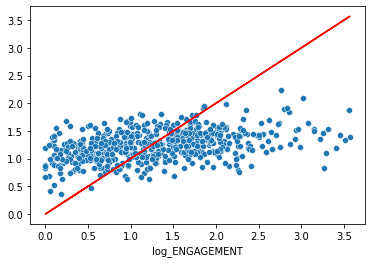

In [785]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [786]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

0.6940918696308298

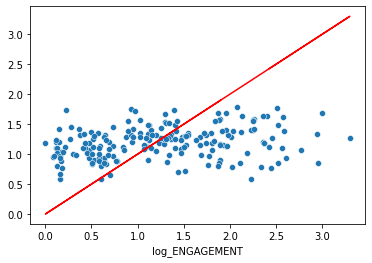

In [787]:
X_test_scaled = my_scaler.transform(X_test)
y_test_pred = knn_model_2.predict(X_test_scaled)

ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [788]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

0.7401667814995223

## Appling 2nd Model - Decision Tree with bins

In [789]:
model_2_dt = DecisionTreeClassifier(
    min_samples_leaf=3
    ,max_depth=5
    )

In [790]:
model_2_dt.fit(X, 
              y_ENGAGEMENT_RANK_INT)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [791]:
class_list = [str(x) for x in model_2_dt.classes_]
class_list

['0', '1', '2', '3', '4']

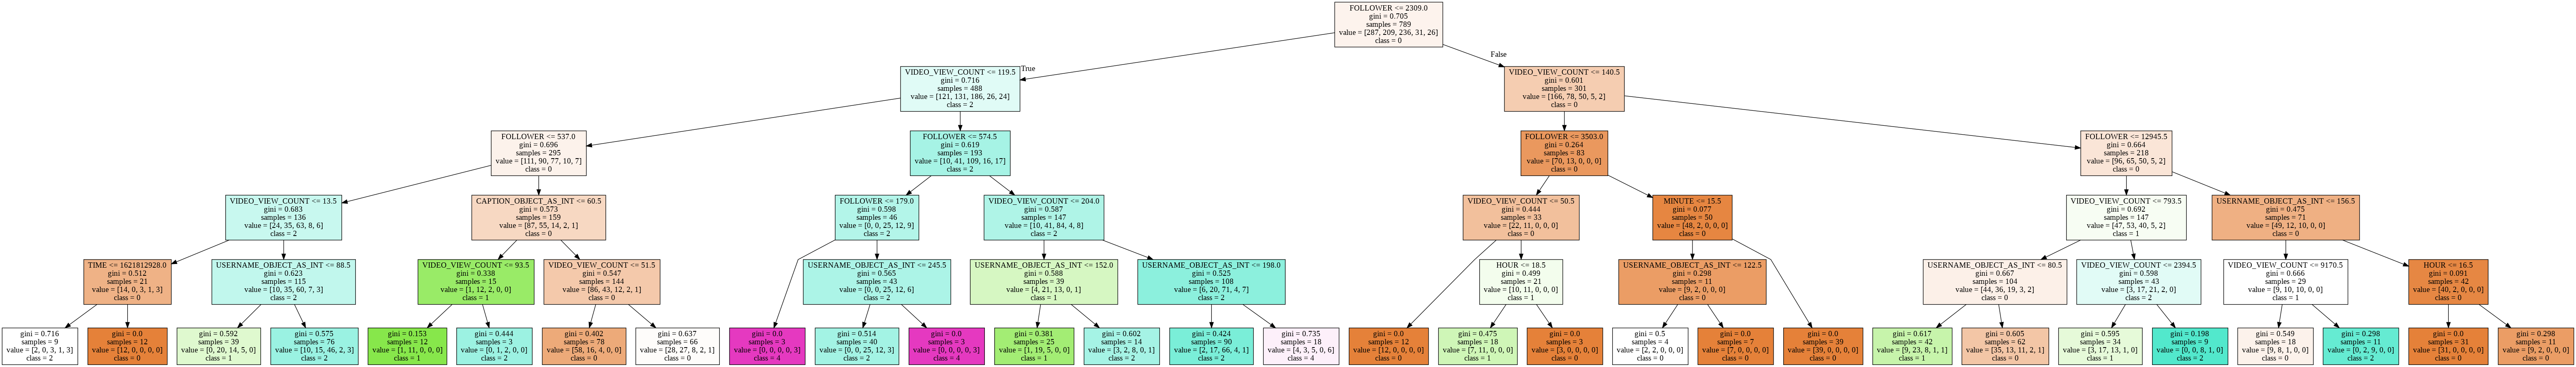

In [792]:
dot_data = StringIO()  
export_graphviz(model_2_dt, out_file=dot_data, feature_names=X.columns, 
                leaves_parallel=True, filled=True, class_names=[str(x) for x in model_2_dt.classes_])
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
Image(graph.create_png(), width=1000) 

View Features Emportance:

In [793]:
pd.Series(model_2_dt.feature_importances_*100,
          index=X.columns).sort_values(ascending=False).round()

VIDEO_VIEW_COUNT                                41.0
FOLLOWER                                        34.0
USERNAME_OBJECT_AS_INT                          18.0
CAPTION_OBJECT_AS_INT                            4.0
TIME                                             2.0
HOUR                                             1.0
MINUTE                                           0.0
LOCATION_OBJECT_AS_INT                           0.0
ACCESSIBILITY_CAPTION_OBJECT_AS_INT              0.0
URL_OBJECT_AS_INT                                0.0
CITY_OBJECT_AS_INT                               0.0
ACCESSIBILITY_CAPTION_INTEREST_OBJECT_AS_INT     0.0
COUNTRY_OBJECT_AS_INT                            0.0
DAYOFWEEK                                        0.0
DAY                                              0.0
MONTH                                            0.0
YEAR                                             0.0
IMAGE_LABELS_OBJECT_AS_INT                       0.0
HAS_AUDIO                                     

Eladk 2021-Sep-24 comment in first model:

*   Why Time is So meaning full?
*   What ACCESSIBILITY_CAPTION have corolation with ranking?
*   I Need to understand why folloer is very meaningfull
*   I Need to understand why USERNAME,userid is very meaningfull

In [794]:
df.head(3)

,USERNAME,FOLLOWER,LIKES,COMMENTS,ENGAGEMENT,URL,ACCESSIBILITY_CAPTION,CAPTION,LOCATION,CITY,COUNTRY,TIME,IMAGE_LABELS,CAPTION_INTEREST,ACCESSIBILITY_CAPTION_INTEREST,IMAGE_LABEL_INTEREST,COMMENT_DISABLED,IS_VIDEO,HAS_AUDIO,VIDEO_VIEW_COUNT,log_ENGAGEMENT,DATETIME,YEAR,MONTH,DAY,DAYOFWEEK,HOUR,MINUTE,LIKES_RANK,COMMENTS_RANK,ENGAGEMENT_RANK,LIKES_RANK_INT,COMMENTS_RANK_INT,ENGAGEMENT_RANK_INT,USERNAME_OBJECT_AS_INT,URL_OBJECT_AS_INT,ACCESSIBILITY_CAPTION_OBJECT_AS_INT,CAPTION_OBJECT_AS_INT,LOCATION_OBJECT_AS_INT,CITY_OBJECT_AS_INT,COUNTRY_OBJECT_AS_INT,IMAGE_LABELS_OBJECT_AS_INT,CAPTION_INTEREST_OBJECT_AS_INT,ACCESSIBILITY_CAPTION_INTEREST_OBJECT_AS_INT,IMAGE_LABEL_INTEREST_OBJECT_AS_INT
LINE_NUM_INDEX,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1930,mr_artworker_,1319,102,8,8.34,https://www.instagram.com/p/CPQ93T1FJfN,Null,????,Null,Null,Null,1621879514,"Chime, Windchime, Musical Instrument, Lighting",education,Null,movies,0,1,1,712.0,2.234306,2021-05-24 18:05:14,2021,5,24,0,18,5,High,High,High,2,2,2,162.0,401.0,0.0,54.0,41.0,36.0,9.0,66.0,8.0,0.0,17.0
1934,mrssugarbrown,6334,20,4,0.38,https://www.instagram.com/p/CP6YUrUAcZY,Null,Left or right??? Right or left ? \nWooooooo won? Me or this bitch Iris? ????????????????????\n.\nDrop it like it’s hot! ????????????????????????\n.\nI love you woo foreva,Null,Null,Null,1623269109,"Person, Human, Text, Indoors, Shoe, Clothing, Footwear, Apparel, People, Photography, Photo, Housing, Building, Advertisement, Room, Poster",desserts_baking,Null,style_fashion,0,1,1,135.0,0.322083,2021-06-09 20:05:09,2021,6,9,2,20,5,Medium,Medium,Low,1,1,0,164.0,328.0,0.0,379.0,41.0,36.0,9.0,636.0,7.0,0.0,25.0
1935,aphrodyssaph,585,5,0,0.85,https://www.instagram.com/p/CCCmAC3g0NJ,Null,Gonna post it on our FB page guys! Link in bio! ✨,Roxas City,"Roxas City, Capiz, Philippines",Philippines,1593480116,"Pants, Clothing, Apparel, Home Decor, Jeans, Denim, Person, Human, Linen, Footwear, Blazer, Jacket, Coat, Shoe",dating_and_relationships,Null,style_fashion,0,1,1,61.0,0.615186,2020-06-30 01:21:56,2020,6,30,1,1,21,Low,Low,Low,0,0,0,21.0,55.0,0.0,252.0,50.0,40.0,10.0,421.0,6.0,0.0,25.0


In [795]:
df['ENGAGEMENT_RANK_INT_pred'] = model_2_dt.predict(X)
df.head(3)

,USERNAME,FOLLOWER,LIKES,COMMENTS,ENGAGEMENT,URL,ACCESSIBILITY_CAPTION,CAPTION,LOCATION,CITY,COUNTRY,TIME,IMAGE_LABELS,CAPTION_INTEREST,ACCESSIBILITY_CAPTION_INTEREST,IMAGE_LABEL_INTEREST,COMMENT_DISABLED,IS_VIDEO,HAS_AUDIO,VIDEO_VIEW_COUNT,log_ENGAGEMENT,DATETIME,YEAR,MONTH,DAY,DAYOFWEEK,HOUR,MINUTE,LIKES_RANK,COMMENTS_RANK,ENGAGEMENT_RANK,LIKES_RANK_INT,COMMENTS_RANK_INT,ENGAGEMENT_RANK_INT,USERNAME_OBJECT_AS_INT,URL_OBJECT_AS_INT,ACCESSIBILITY_CAPTION_OBJECT_AS_INT,CAPTION_OBJECT_AS_INT,LOCATION_OBJECT_AS_INT,CITY_OBJECT_AS_INT,COUNTRY_OBJECT_AS_INT,IMAGE_LABELS_OBJECT_AS_INT,CAPTION_INTEREST_OBJECT_AS_INT,ACCESSIBILITY_CAPTION_INTEREST_OBJECT_AS_INT,IMAGE_LABEL_INTEREST_OBJECT_AS_INT,ENGAGEMENT_RANK_INT_pred
LINE_NUM_INDEX,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1930,mr_artworker_,1319,102,8,8.34,https://www.instagram.com/p/CPQ93T1FJfN,Null,????,Null,Null,Null,1621879514,"Chime, Windchime, Musical Instrument, Lighting",education,Null,movies,0,1,1,712.0,2.234306,2021-05-24 18:05:14,2021,5,24,0,18,5,High,High,High,2,2,2,162.0,401.0,0.0,54.0,41.0,36.0,9.0,66.0,8.0,0.0,17.0,2
1934,mrssugarbrown,6334,20,4,0.38,https://www.instagram.com/p/CP6YUrUAcZY,Null,Left or right??? Right or left ? \nWooooooo won? Me or this bitch Iris? ????????????????????\n.\nDrop it like it’s hot! ????????????????????????\n.\nI love you woo foreva,Null,Null,Null,1623269109,"Person, Human, Text, Indoors, Shoe, Clothing, Footwear, Apparel, People, Photography, Photo, Housing, Building, Advertisement, Room, Poster",desserts_baking,Null,style_fashion,0,1,1,135.0,0.322083,2021-06-09 20:05:09,2021,6,9,2,20,5,Medium,Medium,Low,1,1,0,164.0,328.0,0.0,379.0,41.0,36.0,9.0,636.0,7.0,0.0,25.0,0
1935,aphrodyssaph,585,5,0,0.85,https://www.instagram.com/p/CCCmAC3g0NJ,Null,Gonna post it on our FB page guys! Link in bio! ✨,Roxas City,"Roxas City, Capiz, Philippines",Philippines,1593480116,"Pants, Clothing, Apparel, Home Decor, Jeans, Denim, Person, Human, Linen, Footwear, Blazer, Jacket, Coat, Shoe",dating_and_relationships,Null,style_fashion,0,1,1,61.0,0.615186,2020-06-30 01:21:56,2020,6,30,1,1,21,Low,Low,Low,0,0,0,21.0,55.0,0.0,252.0,50.0,40.0,10.0,421.0,6.0,0.0,25.0,0


In [796]:
# map_dict_ENGAGEMENT = dict(zip(df.ENGAGEMENT_RANK_INT,df.ENGAGEMENT_RANK))
# map_dict_ENGAGEMENT

In [797]:
#df['ENGAGEMENT_RANK_pred'] = df['ENGAGEMENT_RANK_INT_pred'].map(map_dict_ENGAGEMENT)

Evanuating the Model:

In [798]:
#type(df[['ENGAGEMENT_RANK','ENGAGEMENT_RANK_pred']].value_counts())

In [799]:
df[['ENGAGEMENT_RANK_INT','ENGAGEMENT_RANK_INT_pred']].value_counts().sort_index()

ENGAGEMENT_RANK_INT  ENGAGEMENT_RANK_INT_pred
0                    0                           245
                     1                            21
                     2                            17
                     4                             4
1                    0                            68
                     1                           101
                     2                            37
                     4                             3
2                    0                            24
                     1                            40
                     2                           167
                     4                             5
3                    0                             4
                     1                             7
                     2                            20
4                    0                             2
                     1                             1
                     2                            11


In [800]:
#df[['ENGAGEMENT_RANK','ENGAGEMENT_RANK_pred']].value_counts().sort_index()

In [801]:
cm = confusion_matrix(y_true=df.ENGAGEMENT_RANK_INT,
                      y_pred=df.ENGAGEMENT_RANK_INT_pred)
pd.DataFrame(cm,
             index=model_2_dt.classes_,
             columns=model_2_dt.classes_)

,0,1,2,3,4
0,245,21,17,0,4
1,68,101,37,0,3
2,24,40,167,0,5
3,4,7,20,0,0
4,2,1,11,0,12


In [802]:
print(classification_report(y_true=df.ENGAGEMENT_RANK_INT,
                      y_pred=df.ENGAGEMENT_RANK_INT_pred))

              precision    recall  f1-score   support

           0       0.71      0.85      0.78       287
           1       0.59      0.48      0.53       209
           2       0.66      0.71      0.68       236
           3       0.00      0.00      0.00        31
           4       0.50      0.46      0.48        26

    accuracy                           0.67       789
   macro avg       0.49      0.50      0.50       789
weighted avg       0.63      0.67      0.64       789



In [803]:
accuracy_score(y_true=df.ENGAGEMENT_RANK_INT, y_pred=df.ENGAGEMENT_RANK_INT_pred)

0.6653992395437263

In [804]:
s = pd.Series(model_2_dt.feature_importances_*100,
          index=X.columns).sort_values(ascending=False)

s[s.gt(0)]

VIDEO_VIEW_COUNT          41.148879
FOLLOWER                  33.740723
USERNAME_OBJECT_AS_INT    17.961764
CAPTION_OBJECT_AS_INT      3.558228
TIME                       2.111290
HOUR                       1.201713
MINUTE                     0.277403
dtype: float64

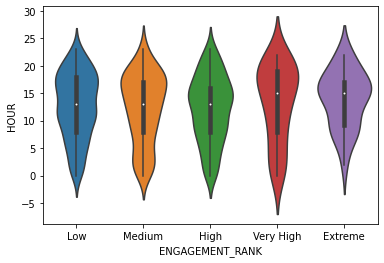

In [805]:
p = sns.violinplot(x='ENGAGEMENT_RANK', y='HOUR', 
                    #order=cut_order, 
                    data=df)

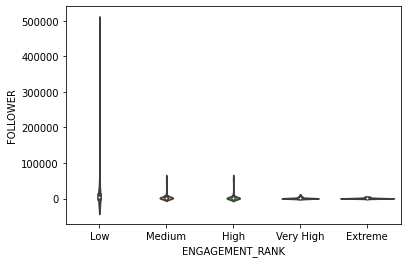

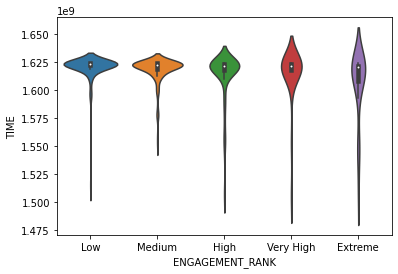

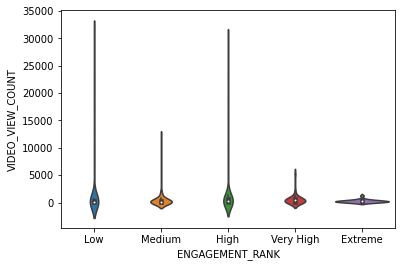

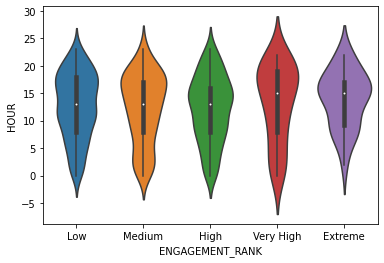

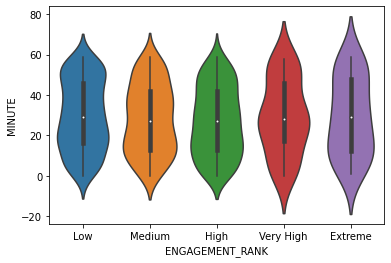

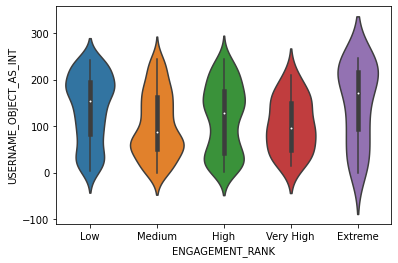

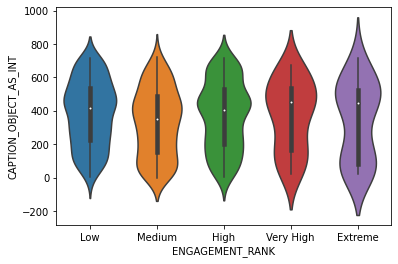

In [806]:
for index, val in pd.Series(model_2_dt.feature_importances_*100,index=X.columns).iteritems():
  if val > 0:
    plt.figure()
    p = sns.violinplot(x='ENGAGEMENT_RANK', y=index, 
                    #order=cut_order, 
                    data=df)
    

## Scoring 

## Appling 3nd Model - Random Forest 

In [807]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = rand_state)
# Train the model on training data
rf.fit(X_train, y_train);

In [808]:
# Use the forest's predict method on the test data
rf_predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(rf_predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'log_of_enegament.')

Mean Absolute Error: 0.36 log_of_enegament.


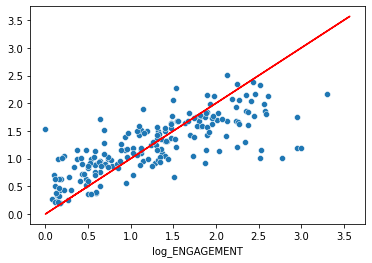

In [809]:
ax = sns.scatterplot(x=y_test, y=rf_predictions)
ax.plot(y_train, y_train, 'r')

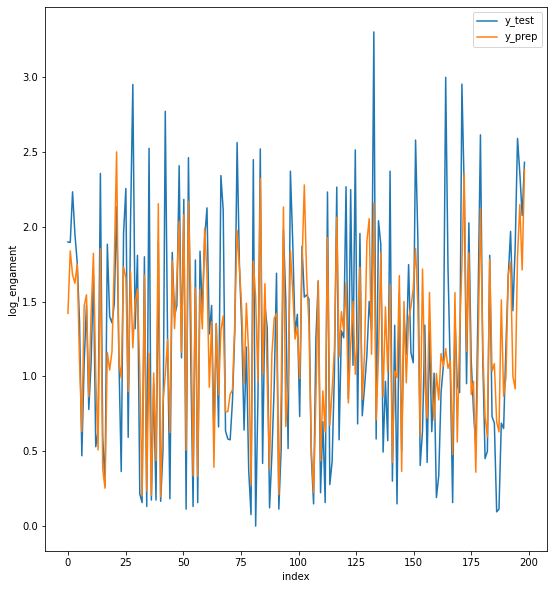

In [810]:
x = np.linspace(0, len(y_test), len(y_test))
fig = plt.figure(figsize=(9, 10))
plt.plot(x, y_test, label='y_test')
plt.plot(x, rf_predictions, label='y_prep')
plt.xlabel('index')
plt.ylabel('log_engament')
plt.legend()
plt.show()

In [811]:
rf_y_train_pred = rf.predict(X_train)
RMSE = mse(y_train, rf_y_train_pred)**0.5
RMSE

0.16814637124116852

In [812]:
pd.Series(rf.feature_importances_, index=X_train.columns).\
sort_values(ascending=False)

FOLLOWER                                        0.339909
VIDEO_VIEW_COUNT                                0.244282
USERNAME_OBJECT_AS_INT                          0.084474
TIME                                            0.067017
URL_OBJECT_AS_INT                               0.033655
CAPTION_OBJECT_AS_INT                           0.033240
IMAGE_LABELS_OBJECT_AS_INT                      0.032925
MINUTE                                          0.028532
HOUR                                            0.024843
CAPTION_INTEREST_OBJECT_AS_INT                  0.020330
IMAGE_LABEL_INTEREST_OBJECT_AS_INT              0.018761
DAY                                             0.017257
DAYOFWEEK                                       0.014010
COMMENT_DISABLED                                0.009810
MONTH                                           0.009643
COUNTRY_OBJECT_AS_INT                           0.007626
LOCATION_OBJECT_AS_INT                          0.006203
CITY_OBJECT_AS_INT             

## Appling 4nd Model - Random Forest Classification 

In [835]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, y_ENGAGEMENT_RANK_INT, train_size = train_size\
                           , random_state = rand_state)#, stratify = df.ENGAGEMENT)

In [836]:
X_train_4.drop(columns='VIDEO_VIEW_COUNT', inplace=True)
X_test_4.drop(columns='VIDEO_VIEW_COUNT', inplace=True)

In [837]:
X_train_4.columns

Index(['FOLLOWER', 'TIME', 'COMMENT_DISABLED', 'IS_VIDEO', 'HAS_AUDIO', 'YEAR',
       'MONTH', 'DAY', 'DAYOFWEEK', 'HOUR', 'MINUTE', 'USERNAME_OBJECT_AS_INT',
       'URL_OBJECT_AS_INT', 'ACCESSIBILITY_CAPTION_OBJECT_AS_INT',
       'CAPTION_OBJECT_AS_INT', 'LOCATION_OBJECT_AS_INT', 'CITY_OBJECT_AS_INT',
       'COUNTRY_OBJECT_AS_INT', 'IMAGE_LABELS_OBJECT_AS_INT',
       'CAPTION_INTEREST_OBJECT_AS_INT',
       'ACCESSIBILITY_CAPTION_INTEREST_OBJECT_AS_INT',
       'IMAGE_LABEL_INTEREST_OBJECT_AS_INT'],
      dtype='object')

In [838]:
model_rf_4 = RandomForestClassifier()

model_rf_4.fit(X_train_4,y_train_4) # X_test_4 is Engagment_rank
preds= model_rf_4.predict_proba(X_train_4)[:,1]

#roc_auc_score(y_test_4,preds)

In [839]:
# map_dict_ENGAGEMENT = dict(zip(df.ENGAGEMENT_RANK_INT,df.ENGAGEMENT_RANK))

In [840]:
pd.Series(model_rf_4.feature_importances_*100, index=X_train_4.columns).sort_values(ascending=False).round()#.plot.barh(figsize=(14,12))

FOLLOWER                                        12.0
USERNAME_OBJECT_AS_INT                          10.0
TIME                                             9.0
CAPTION_OBJECT_AS_INT                            8.0
URL_OBJECT_AS_INT                                8.0
IMAGE_LABELS_OBJECT_AS_INT                       8.0
MINUTE                                           7.0
HOUR                                             7.0
DAY                                              6.0
CAPTION_INTEREST_OBJECT_AS_INT                   6.0
IMAGE_LABEL_INTEREST_OBJECT_AS_INT               5.0
DAYOFWEEK                                        4.0
MONTH                                            3.0
LOCATION_OBJECT_AS_INT                           1.0
CITY_OBJECT_AS_INT                               1.0
COUNTRY_OBJECT_AS_INT                            1.0
HAS_AUDIO                                        1.0
YEAR                                             1.0
COMMENT_DISABLED                              

In [842]:
from sklearn import tree

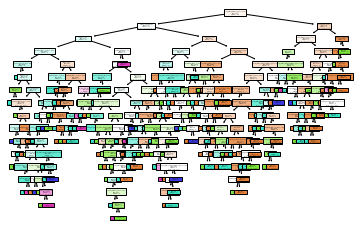

In [843]:
_ = tree.plot_tree(model_rf_4.estimators_[0], feature_names=X_train_4.columns, filled=True)

In [844]:
import six

In [845]:
X_train_4.columns

Index(['FOLLOWER', 'TIME', 'COMMENT_DISABLED', 'IS_VIDEO', 'HAS_AUDIO', 'YEAR',
       'MONTH', 'DAY', 'DAYOFWEEK', 'HOUR', 'MINUTE', 'USERNAME_OBJECT_AS_INT',
       'URL_OBJECT_AS_INT', 'ACCESSIBILITY_CAPTION_OBJECT_AS_INT',
       'CAPTION_OBJECT_AS_INT', 'LOCATION_OBJECT_AS_INT', 'CITY_OBJECT_AS_INT',
       'COUNTRY_OBJECT_AS_INT', 'IMAGE_LABELS_OBJECT_AS_INT',
       'CAPTION_INTEREST_OBJECT_AS_INT',
       'ACCESSIBILITY_CAPTION_INTEREST_OBJECT_AS_INT',
       'IMAGE_LABEL_INTEREST_OBJECT_AS_INT'],
      dtype='object')

In [846]:
X_train_4.head(3)

,FOLLOWER,TIME,COMMENT_DISABLED,IS_VIDEO,HAS_AUDIO,YEAR,MONTH,DAY,DAYOFWEEK,HOUR,MINUTE,USERNAME_OBJECT_AS_INT,URL_OBJECT_AS_INT,ACCESSIBILITY_CAPTION_OBJECT_AS_INT,CAPTION_OBJECT_AS_INT,LOCATION_OBJECT_AS_INT,CITY_OBJECT_AS_INT,COUNTRY_OBJECT_AS_INT,IMAGE_LABELS_OBJECT_AS_INT,CAPTION_INTEREST_OBJECT_AS_INT,ACCESSIBILITY_CAPTION_INTEREST_OBJECT_AS_INT,IMAGE_LABEL_INTEREST_OBJECT_AS_INT
LINE_NUM_INDEX,,,,,,,,,,,,,,,,,,,,,,
5846,9799,1623052704,0,1,1,2021,6,7,0,7,58,128.0,520.0,0.0,90.0,41.0,36.0,9.0,692.0,26.0,0.0,25.0
5247,491,1618173631,0,1,1,2021,4,11,6,20,40,89.0,184.0,0.0,450.0,41.0,36.0,9.0,227.0,0.0,0.0,25.0
3454,10621,1623319369,0,1,1,2021,6,10,3,10,2,35.0,334.0,0.0,471.0,41.0,36.0,9.0,547.0,26.0,0.0,25.0


In [847]:
X_train_4['y_ENGAGEMENT_RANK_INT_pred_rf'] = model_rf_4.predict(X_train_4)

In [848]:
X_train_4.head(3)

,FOLLOWER,TIME,COMMENT_DISABLED,IS_VIDEO,HAS_AUDIO,YEAR,MONTH,DAY,DAYOFWEEK,HOUR,MINUTE,USERNAME_OBJECT_AS_INT,URL_OBJECT_AS_INT,ACCESSIBILITY_CAPTION_OBJECT_AS_INT,CAPTION_OBJECT_AS_INT,LOCATION_OBJECT_AS_INT,CITY_OBJECT_AS_INT,COUNTRY_OBJECT_AS_INT,IMAGE_LABELS_OBJECT_AS_INT,CAPTION_INTEREST_OBJECT_AS_INT,ACCESSIBILITY_CAPTION_INTEREST_OBJECT_AS_INT,IMAGE_LABEL_INTEREST_OBJECT_AS_INT,y_ENGAGEMENT_RANK_INT_pred_rf
LINE_NUM_INDEX,,,,,,,,,,,,,,,,,,,,,,,
5846,9799,1623052704,0,1,1,2021,6,7,0,7,58,128.0,520.0,0.0,90.0,41.0,36.0,9.0,692.0,26.0,0.0,25.0,0
5247,491,1618173631,0,1,1,2021,4,11,6,20,40,89.0,184.0,0.0,450.0,41.0,36.0,9.0,227.0,0.0,0.0,25.0,2
3454,10621,1623319369,0,1,1,2021,6,10,3,10,2,35.0,334.0,0.0,471.0,41.0,36.0,9.0,547.0,26.0,0.0,25.0,0


In [849]:
X_train_4 = pd.concat([X_train_4, y_train_4], axis=1).reset_index()

In [850]:
X_train_4.head(3)

,LINE_NUM_INDEX,FOLLOWER,TIME,COMMENT_DISABLED,IS_VIDEO,HAS_AUDIO,YEAR,MONTH,DAY,DAYOFWEEK,HOUR,MINUTE,USERNAME_OBJECT_AS_INT,URL_OBJECT_AS_INT,ACCESSIBILITY_CAPTION_OBJECT_AS_INT,CAPTION_OBJECT_AS_INT,LOCATION_OBJECT_AS_INT,CITY_OBJECT_AS_INT,COUNTRY_OBJECT_AS_INT,IMAGE_LABELS_OBJECT_AS_INT,CAPTION_INTEREST_OBJECT_AS_INT,ACCESSIBILITY_CAPTION_INTEREST_OBJECT_AS_INT,IMAGE_LABEL_INTEREST_OBJECT_AS_INT,y_ENGAGEMENT_RANK_INT_pred_rf,ENGAGEMENT_RANK_INT
0,5846,9799,1623052704,0,1,1,2021,6,7,0,7,58,128.0,520.0,0.0,90.0,41.0,36.0,9.0,692.0,26.0,0.0,25.0,0,0
1,5247,491,1618173631,0,1,1,2021,4,11,6,20,40,89.0,184.0,0.0,450.0,41.0,36.0,9.0,227.0,0.0,0.0,25.0,2,2
2,3454,10621,1623319369,0,1,1,2021,6,10,3,10,2,35.0,334.0,0.0,471.0,41.0,36.0,9.0,547.0,26.0,0.0,25.0,0,0


In [851]:
cm = confusion_matrix(y_true=y_train_4,
                      y_pred=X_train_4['y_ENGAGEMENT_RANK_INT_pred_rf'])
pd.DataFrame(cm,
             index=model_rf_4.classes_,
             columns=model_rf_4.classes_)

,0,1,2,3,4
0,214,0,0,0,0
1,0,155,0,0,0
2,0,0,181,0,0
3,0,0,0,19,0
4,0,0,0,0,22


Visualize the Random Forest:

In [852]:
# dotfile = six.StringIO()
# i_tree = 0
# for tree_in_forest in model_rf_4.estimators_:
#   if (i_tree <1):        
#       export_graphviz(model_rf_4,
#                   feature_names=X_train_4.columns,
#                   filled=True,
#                   rounded=True)
#       pydotplus.graph_from_dot_data(dotfile.getvalue()).write_png('dtree'+ str(i_tree) +'.png')
#       i_tree = i_tree + 1